#  Sentinel-2 image matching demo

In [8]:
# import a libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image, ImageEnhance
import cv2
import matplotlib.pyplot as plt

In [2]:
# check for available devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}\n")

Current device: cuda



In [3]:
# link to the test dataset
dataset_test_root = r"Sentinel_2_dataset\test"

# retrieve a list of image paths from the test directory
all_filenames_test = []
for dirpath, dirnames, filenames in os.walk(dataset_test_root):
    for filename in filenames:
        if dirpath == dataset_test_root:
            continue
        all_filenames_test.append(os.path.join(dirpath, filename))
        
def select_samples(images):
    """
    Selects unique samples based on location and season from a list of image paths.

    Arguments:
    - images (list): List of image paths.

    Returns:
    - list(selected_images.values()): List of selected unique image paths.
    """
    selected_images = {}
    for img_path in images:
        parts = img_path.split(os.path.sep)
        location = parts[-2]
        season = parts[-1].split('_')[-2]
        key = f"{location}_{season}"
        if key not in selected_images:
            selected_images[key] = img_path
            
    return list(selected_images.values())

# select unique samples
all_filenames_test_prepared = select_samples(all_filenames_test)
print(f"There are {len(all_filenames_test_prepared)} instances for inference")

There are 400 instances for inference


In [4]:
class SiameseNetwork(nn.Module):
    """
    Siamese Neural Network architecture for triplet loss.

    This network takes in triplets of images (anchor, positive, negative),
    processes them through shared convolutional layers, and produces embeddings.

    Architecture:
    - Base Convolutional Neural Network with customizable layers.
    - Fully connected layers for embedding.

    Methods:
    - __init__: Initializes the SiameseNetwork.
    - forward_once: Forward pass through the network for a single image.
    - forward: Forward pass for anchor, positive, and negative samples.
    """
    def __init__(self):
        """
        Initializes the SiameseNetwork architecture.

        Defines a base convolutional neural network and fully connected layers for embedding.
        """
        super().__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256)
        )

    def forward_once(self, x):
        """
        Forward pass through the base network and fully connected layers for a single image.

        - x: Input image tensor.

        Returns:
        - Embedding tensor for the input image.
        """
        x = self.conv_base(x)
        x = x.view(x.size()[0], -1) 
        x = self.fc(x)
        return x

    def forward(self, anchor, positive, negative):
        """
        Forward pass for anchor, positive, and negative samples.

        - anchor: Tensor for the anchor image.
        - positive: Tensor for the positive image.
        - negative: Tensor for the negative image.

        Returns:
        - Embeddings for the anchor, positive, and negative images.
        """
        anchor_emb = self.forward_once(anchor)
        positive_emb = self.forward_once(positive)
        negative_emb = self.forward_once(negative)
        return anchor_emb, positive_emb, negative_emb
    
class BrightnessEnhancement(object):
    """
    Custom transformation class to enhance the brightness of an image.

    Arguments:
    - factor (float): Enhancement factor for brightness adjustment.
    """
    def __init__(self, factor):
        """
        Initializes the BrightnessEnhancement transformation.

        - factor: Enhancement factor for brightness adjustment.
        """
        self.factor = factor

    def __call__(self, img):
        """
        Performs the brightness enhancement on the input image.

        - img: Input image to be enhanced.

        Returns:
        - enhanced_img: Image with adjusted brightness.
        """
        enhancer = ImageEnhance.Brightness(img)
        enhanced_img = enhancer.enhance(self.factor)
        return enhanced_img

In [5]:
# Define the transformations 
transform = transforms.Compose([
    BrightnessEnhancement(factor=3),
    transforms.ToTensor()
])

In [6]:
# load model weights
directory = "models"
model = SiameseNetwork()
model.load_state_dict(torch.load(os.path.join(directory, 'siamese_model.pth')))
model = model.to(device)

In [9]:
# create a dictionary with image file paths and their corresponding embeddings
embeddings = {}
with torch.inference_mode():
    for file in all_filenames_test_prepared:
        img = Image.open(file).convert('RGB')
        img_prepared = transform(img).unsqueeze(0)
        embedding = model.forward_once(img_prepared.to(device))
        embeddings[file] = embedding.cpu().detach().numpy()

In [10]:
def find_most_similar_embeddings(target_filename, embeddings_dict, top_n=1):
    """
    Finds the most similar embeddings to a target embedding from a dictionary of embeddings.

    Arguments:
    - target_filename (str): Filename of the target embedding.
    - embeddings_dict (dict): Dictionary containing filenames as keys and embeddings as values.
    - top_n (int): Number of most similar embeddings to retrieve. Defaults to 5.

    Returns:
    - most_similar (list): List of filenames for the most similar embeddings.
    """
    target_embedding = torch.tensor(embeddings_dict[target_filename])

    similarities = {}
    for filename, embedding in embeddings_dict.items():
        if filename != target_filename:
            embedding_tensor = torch.tensor(embedding)
            similarity_score = torch.cosine_similarity(target_embedding, embedding_tensor).item()
            similarities[filename] = similarity_score

    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    most_similar = [filename for filename, _ in sorted_similarities[:top_n]]

    return most_similar

In [50]:
def adjust_brightness(image, factor, bright_threshold=127, dark_threshold=127):
    """
    Adjusts the brightness of an image based on mean intensity and specified thresholds.

    Arguments:
    - image (np.array): Input image array.
    - factor (float): Brightness adjustment factor.
    - bright_threshold (int): Threshold for identifying bright images. Defaults to 127.
    - dark_threshold (int): Threshold for identifying dark images. Defaults to 127.

    Returns:
    - adjusted_image (np.array): Image with adjusted brightness.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2]
    mean_intensity = np.mean(v)

    if mean_intensity > bright_threshold:
        v = np.where((255 - v) < (factor - 1) * 255, 255, v * factor).astype(np.uint8)
    elif mean_intensity < dark_threshold:
        v = (v * factor).astype(np.uint8)
    
    hsv[:, :, 2] = v
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def get_random_image_and_predict_the_most_similar(filenames, 
                                                  embeddings_dict, 
                                                  top_n=3, 
                                                  factor=1,
                                                  bright_threshold=127, 
                                                  dark_threshold=127):
    """
    Randomly select an image, adjust its brightness, and apply the Scale-Invariant Feature Transform (SIFT) 
    to find the most similar image predicted by the Siamese model.

    Arguments:
    - filenames (list): List of filenames.
    - embeddings_dict (dict): Dictionary containing filenames as keys and embeddings as values.
    - top_n (int): Number of most similar images to predict. Defaults to 3.
    - factor (float): Brightness adjustment factor. Defaults to 1.
    - bright_threshold (int): Threshold for identifying bright images. Defaults to 127.
    - dark_threshold (int): Threshold for identifying dark images. Defaults to 127.

    Prints:
    - Matching result visualization using SIFT for the most similar images.
    """
    anchor_image_path = random.choice(filenames)
    anchor_image_tensor = torch.tensor(embeddings_dict[anchor_image_path])

    the_most_similar_images_paths = find_most_similar_embeddings(anchor_image_path, embeddings_dict, top_n=top_n)
    
    sift = cv2.SIFT_create(contrastThreshold=0.02, edgeThreshold=25, sigma=2.0)
    
    for similar_image_path in the_most_similar_images_paths:
        anchor_image = np.array(Image.open(anchor_image_path).convert('RGB'))
        similar_image = np.array(Image.open(similar_image_path).convert('RGB'))

        adjusted_anchor_image = adjust_brightness(anchor_image, factor, bright_threshold,  dark_threshold)
        adjusted_similar_image = adjust_brightness(similar_image, factor, bright_threshold,  dark_threshold)

        gray_image1 = cv2.cvtColor(adjusted_anchor_image, cv2.COLOR_RGB2GRAY)
        gray_image2 = cv2.cvtColor(adjusted_similar_image, cv2.COLOR_RGB2GRAY)

        keypoints1, descriptors1 = sift.detectAndCompute(gray_image1, None)
        keypoints2, descriptors2 = sift.detectAndCompute(gray_image2, None)

        if descriptors1 is not None and descriptors2 is not None:
            
            descriptors1 = descriptors1.astype(np.float32)
            descriptors2 = descriptors2.astype(np.float32)

            bf = cv2.BFMatcher()
            matches = bf.knnMatch(descriptors1, descriptors2, k=2)

            good_matches = []
            for m in matches:
                if len(m) == 2:
                    m, n = m
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)

            if len(good_matches) > 0:
                mean_distance = sum(m.distance for m in good_matches) / len(good_matches)
            else:
                mean_distance = 0.0

            # Update this part to handle grayscale images for visualization
            matching_result = cv2.drawMatches(gray_image1, keypoints1, gray_image2, keypoints2, good_matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

            plt.figure(figsize=(12,6), dpi=300)
            plt.imshow(matching_result, cmap='gray')
            plt.axis('off')
            plt.title(f'Matching Result | Number of good matches: {len(good_matches)} | Mean keypoint distance: {mean_distance}')
            plt.show()
        else:
            print("SIFT failed to compute descriptors for one of the images.")

## Demo interface
###### You can rerun the cell below to randomly select a test image. The algorithm finds the desired number of the most similar embeddings using the Siamese model and applies SIFT to them.

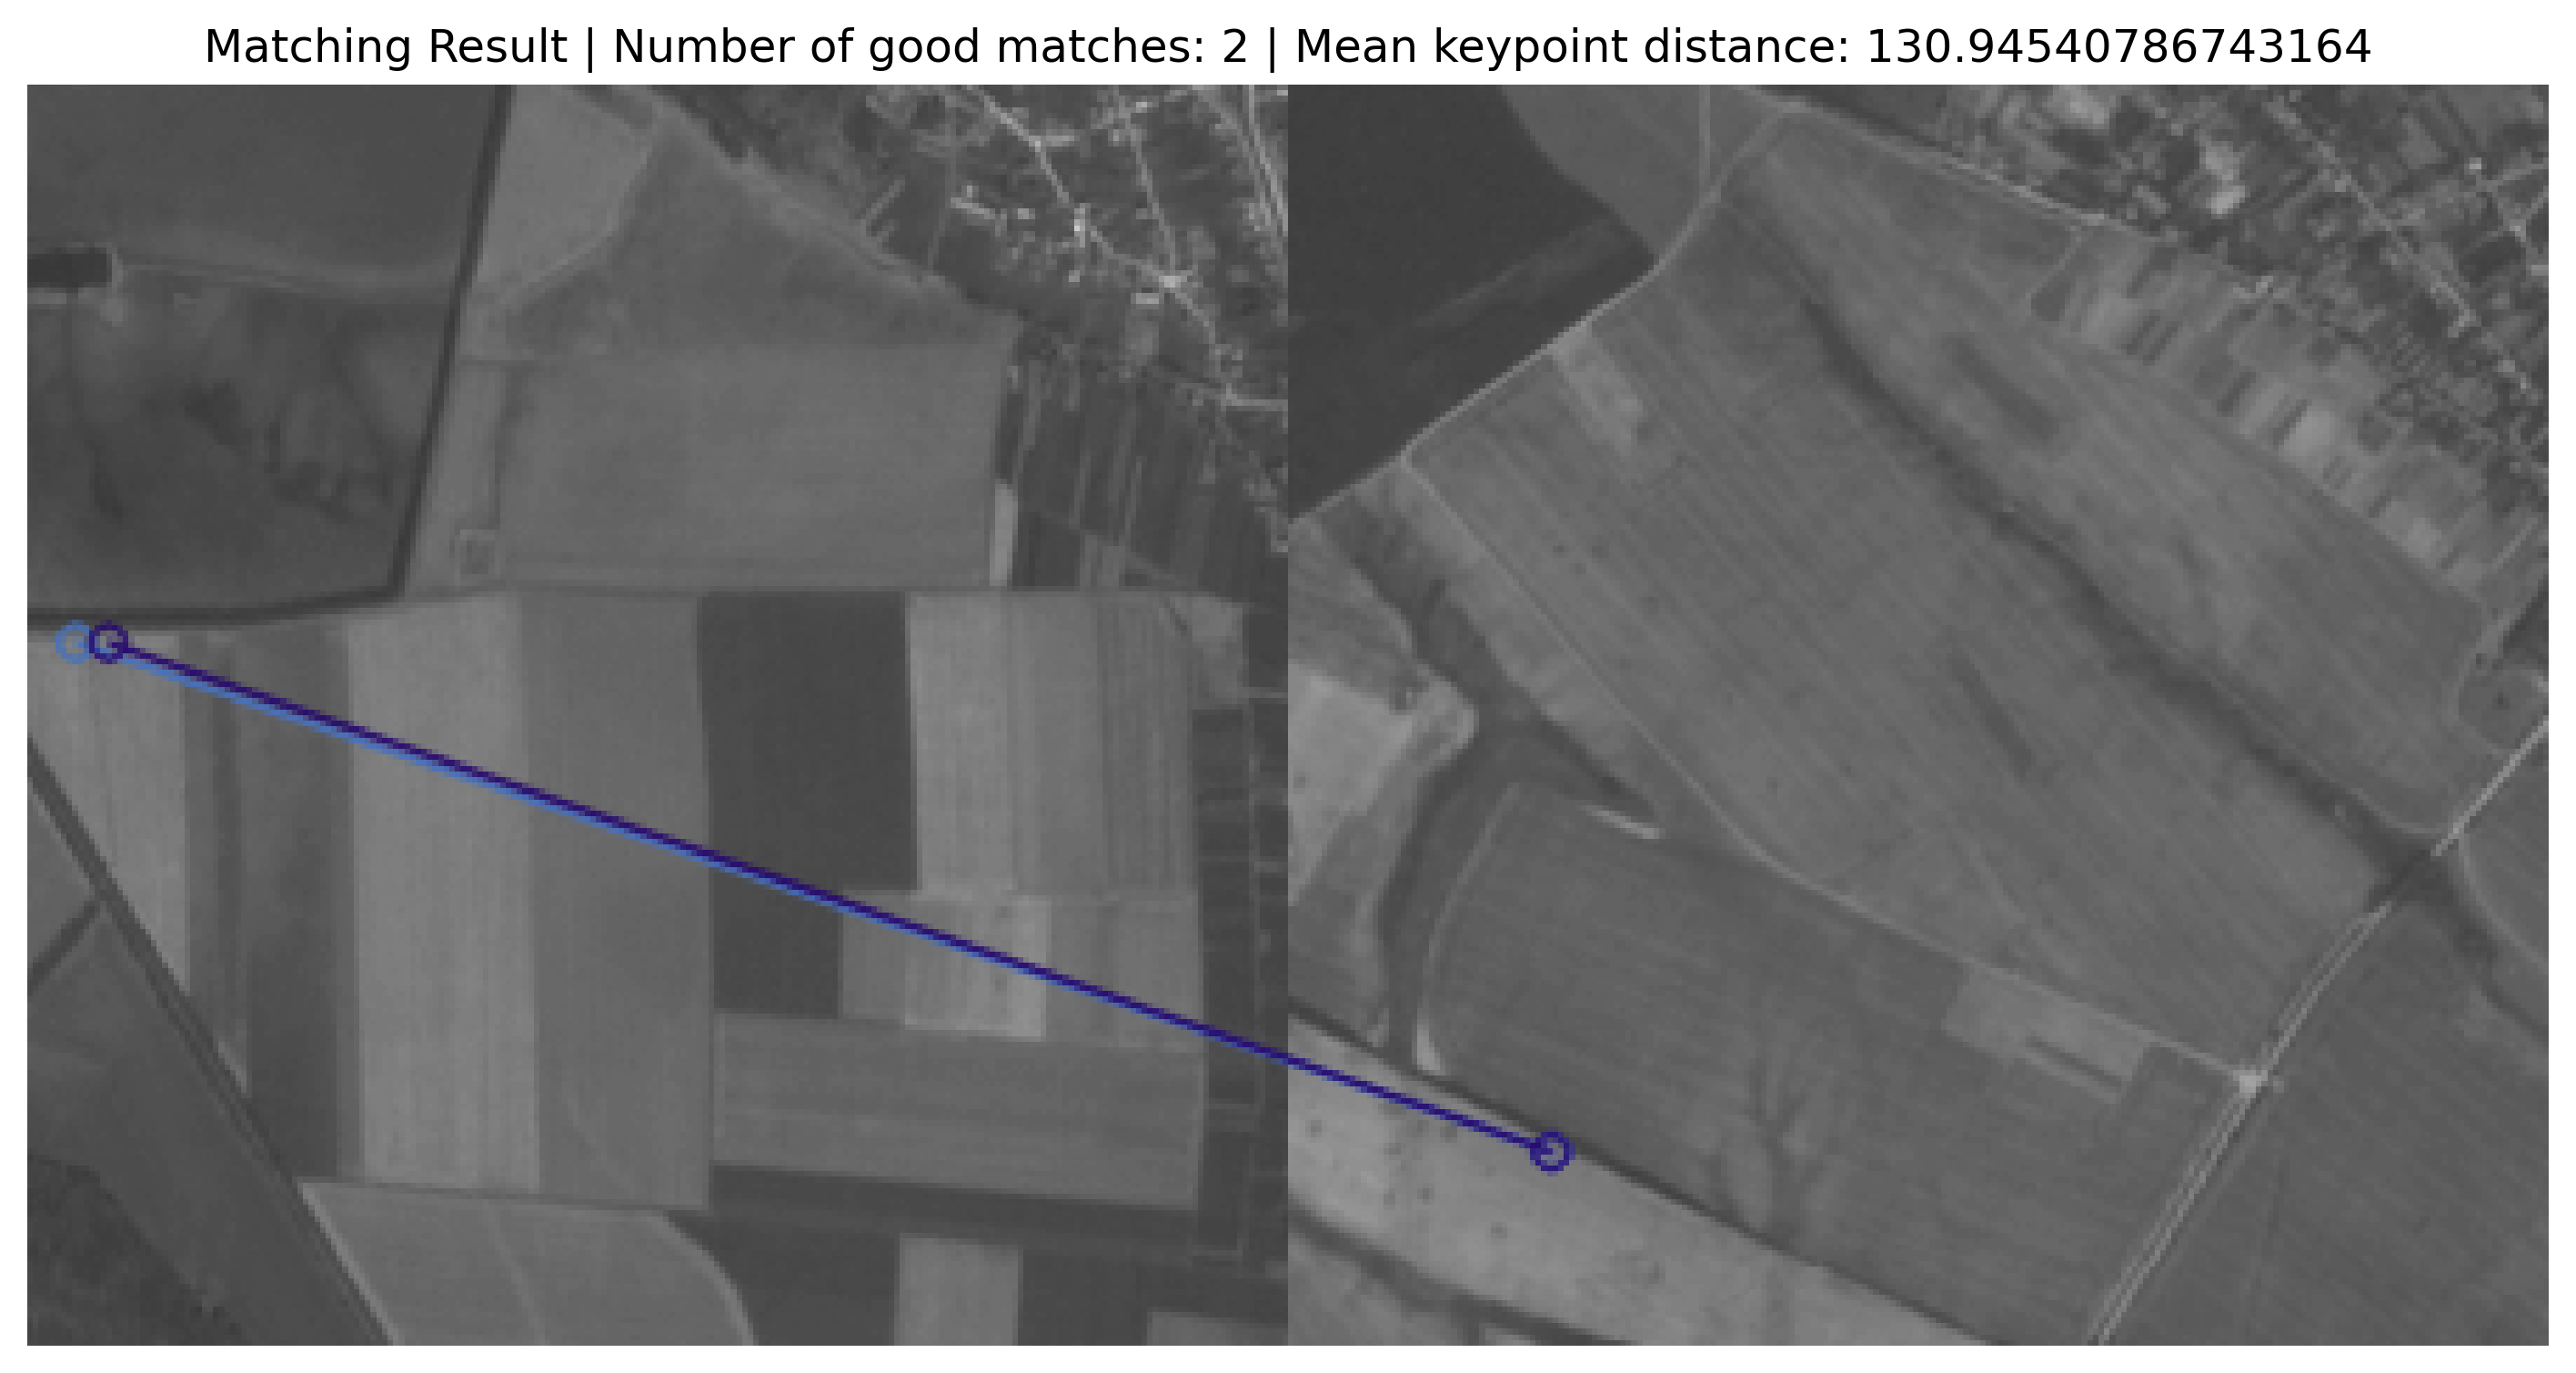

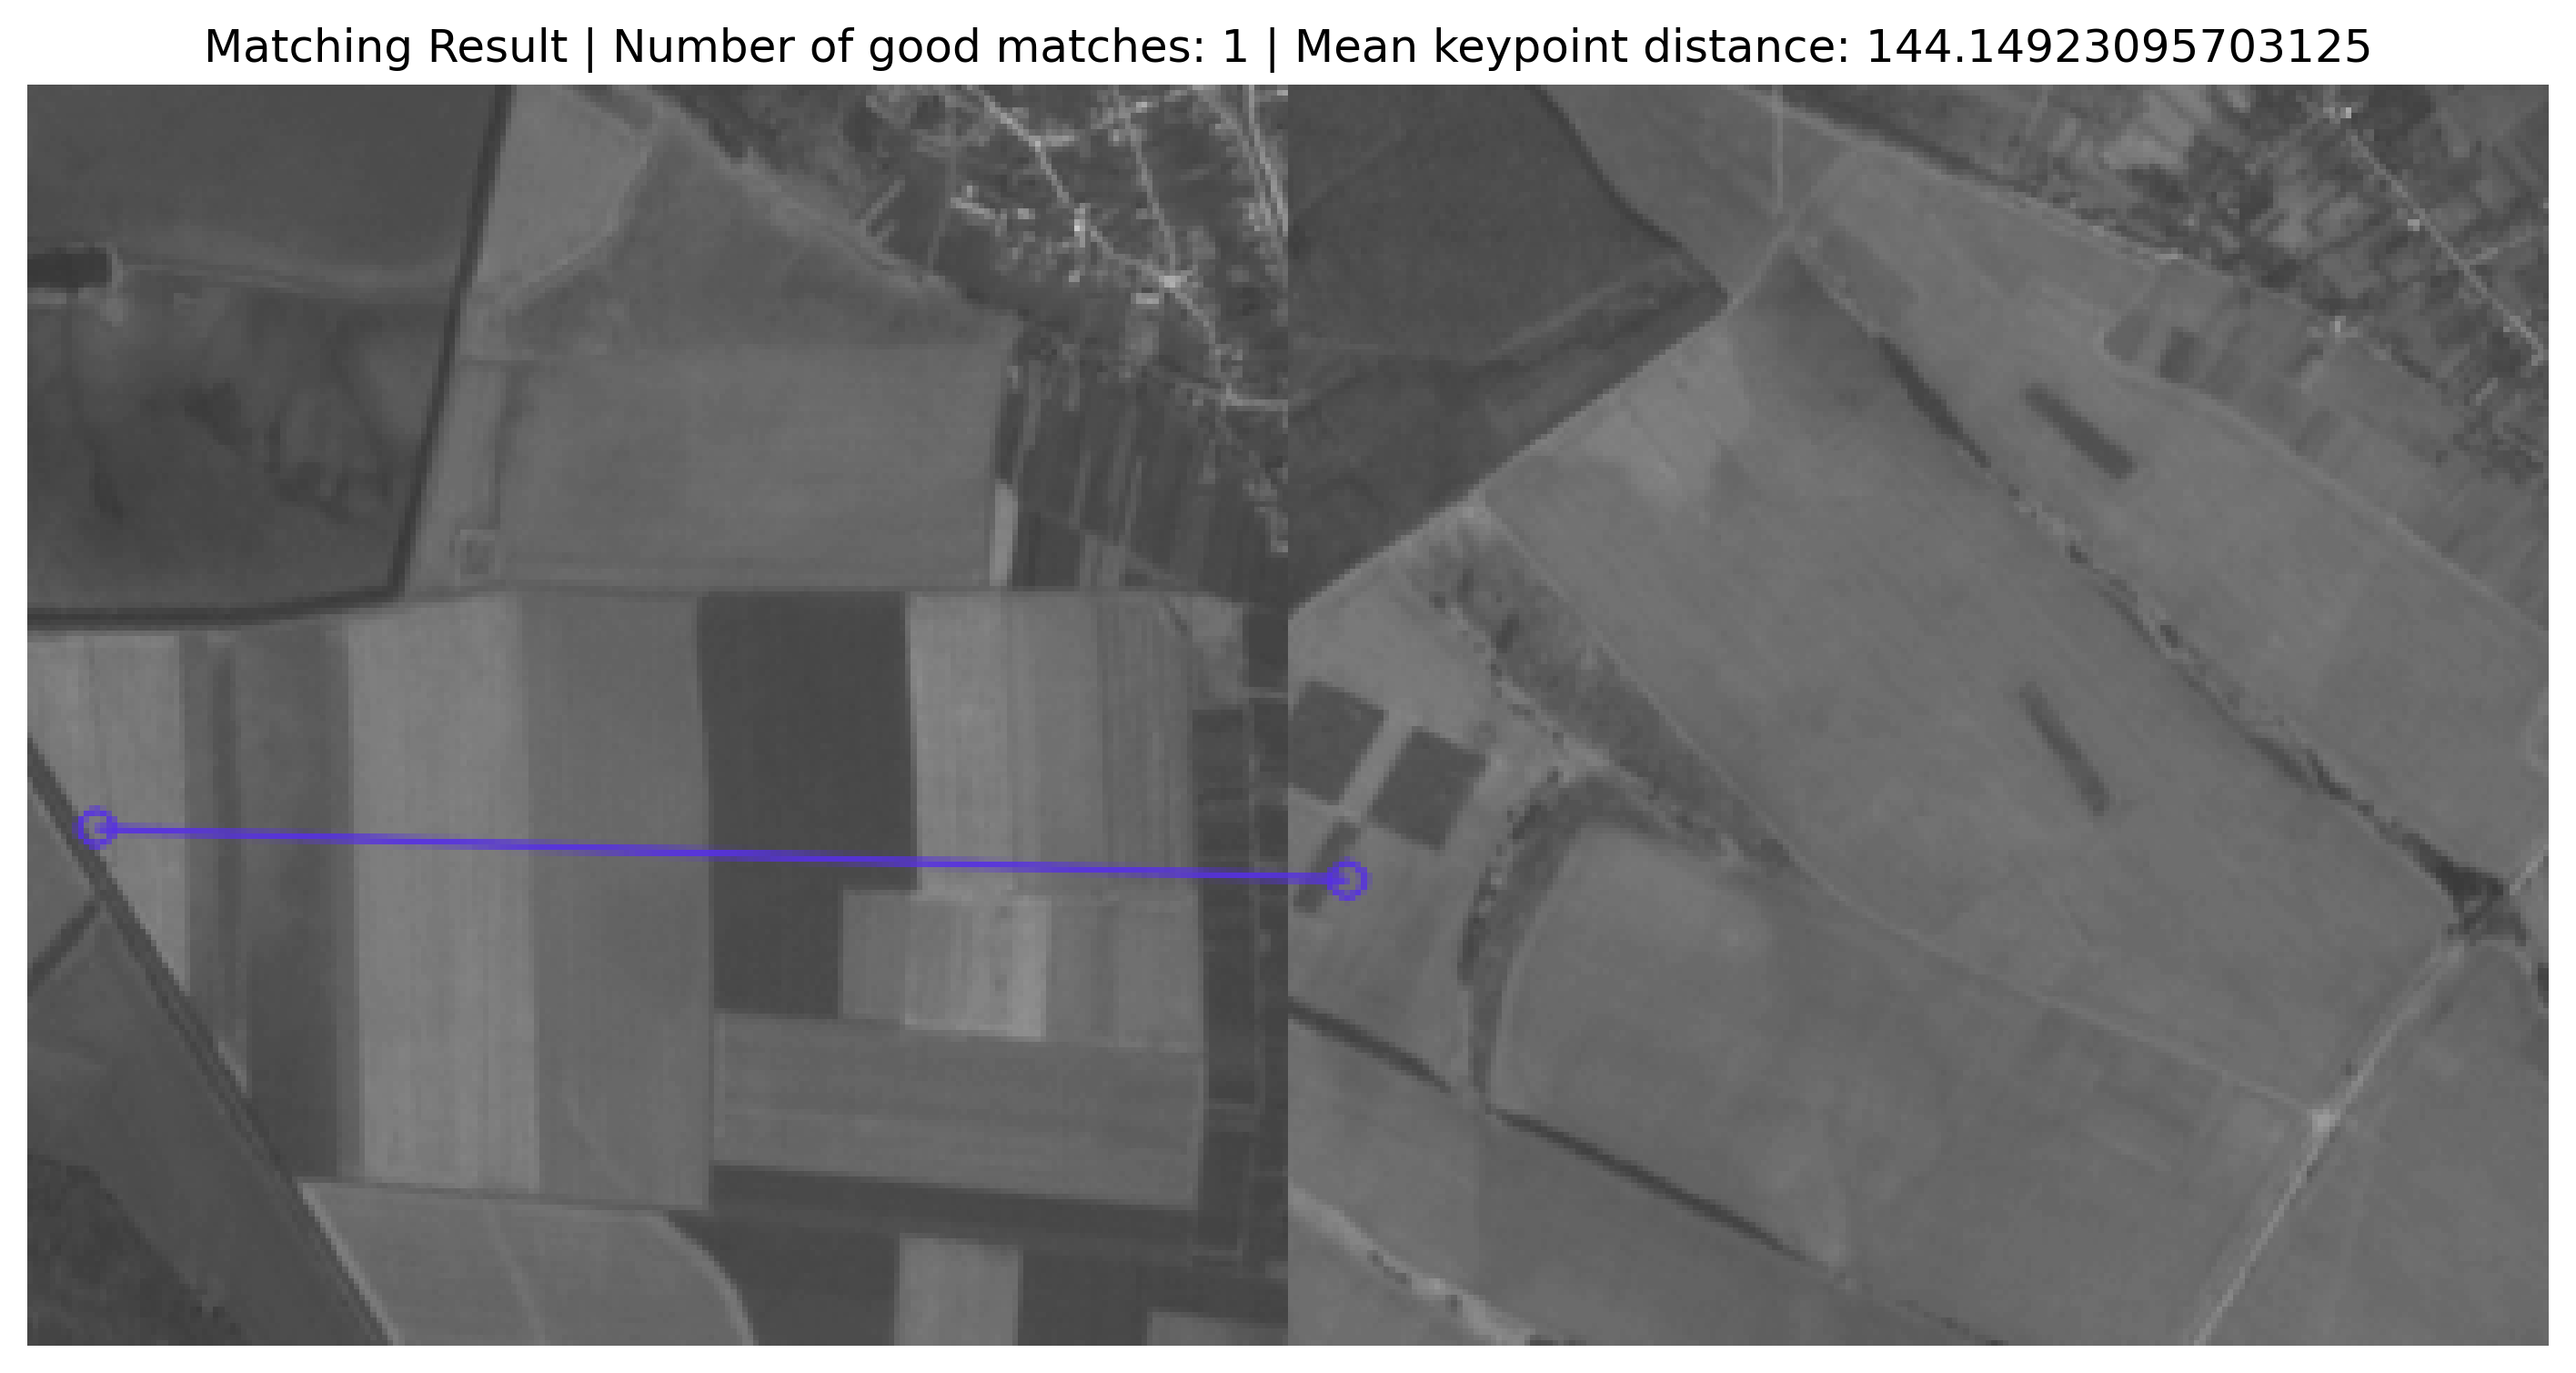

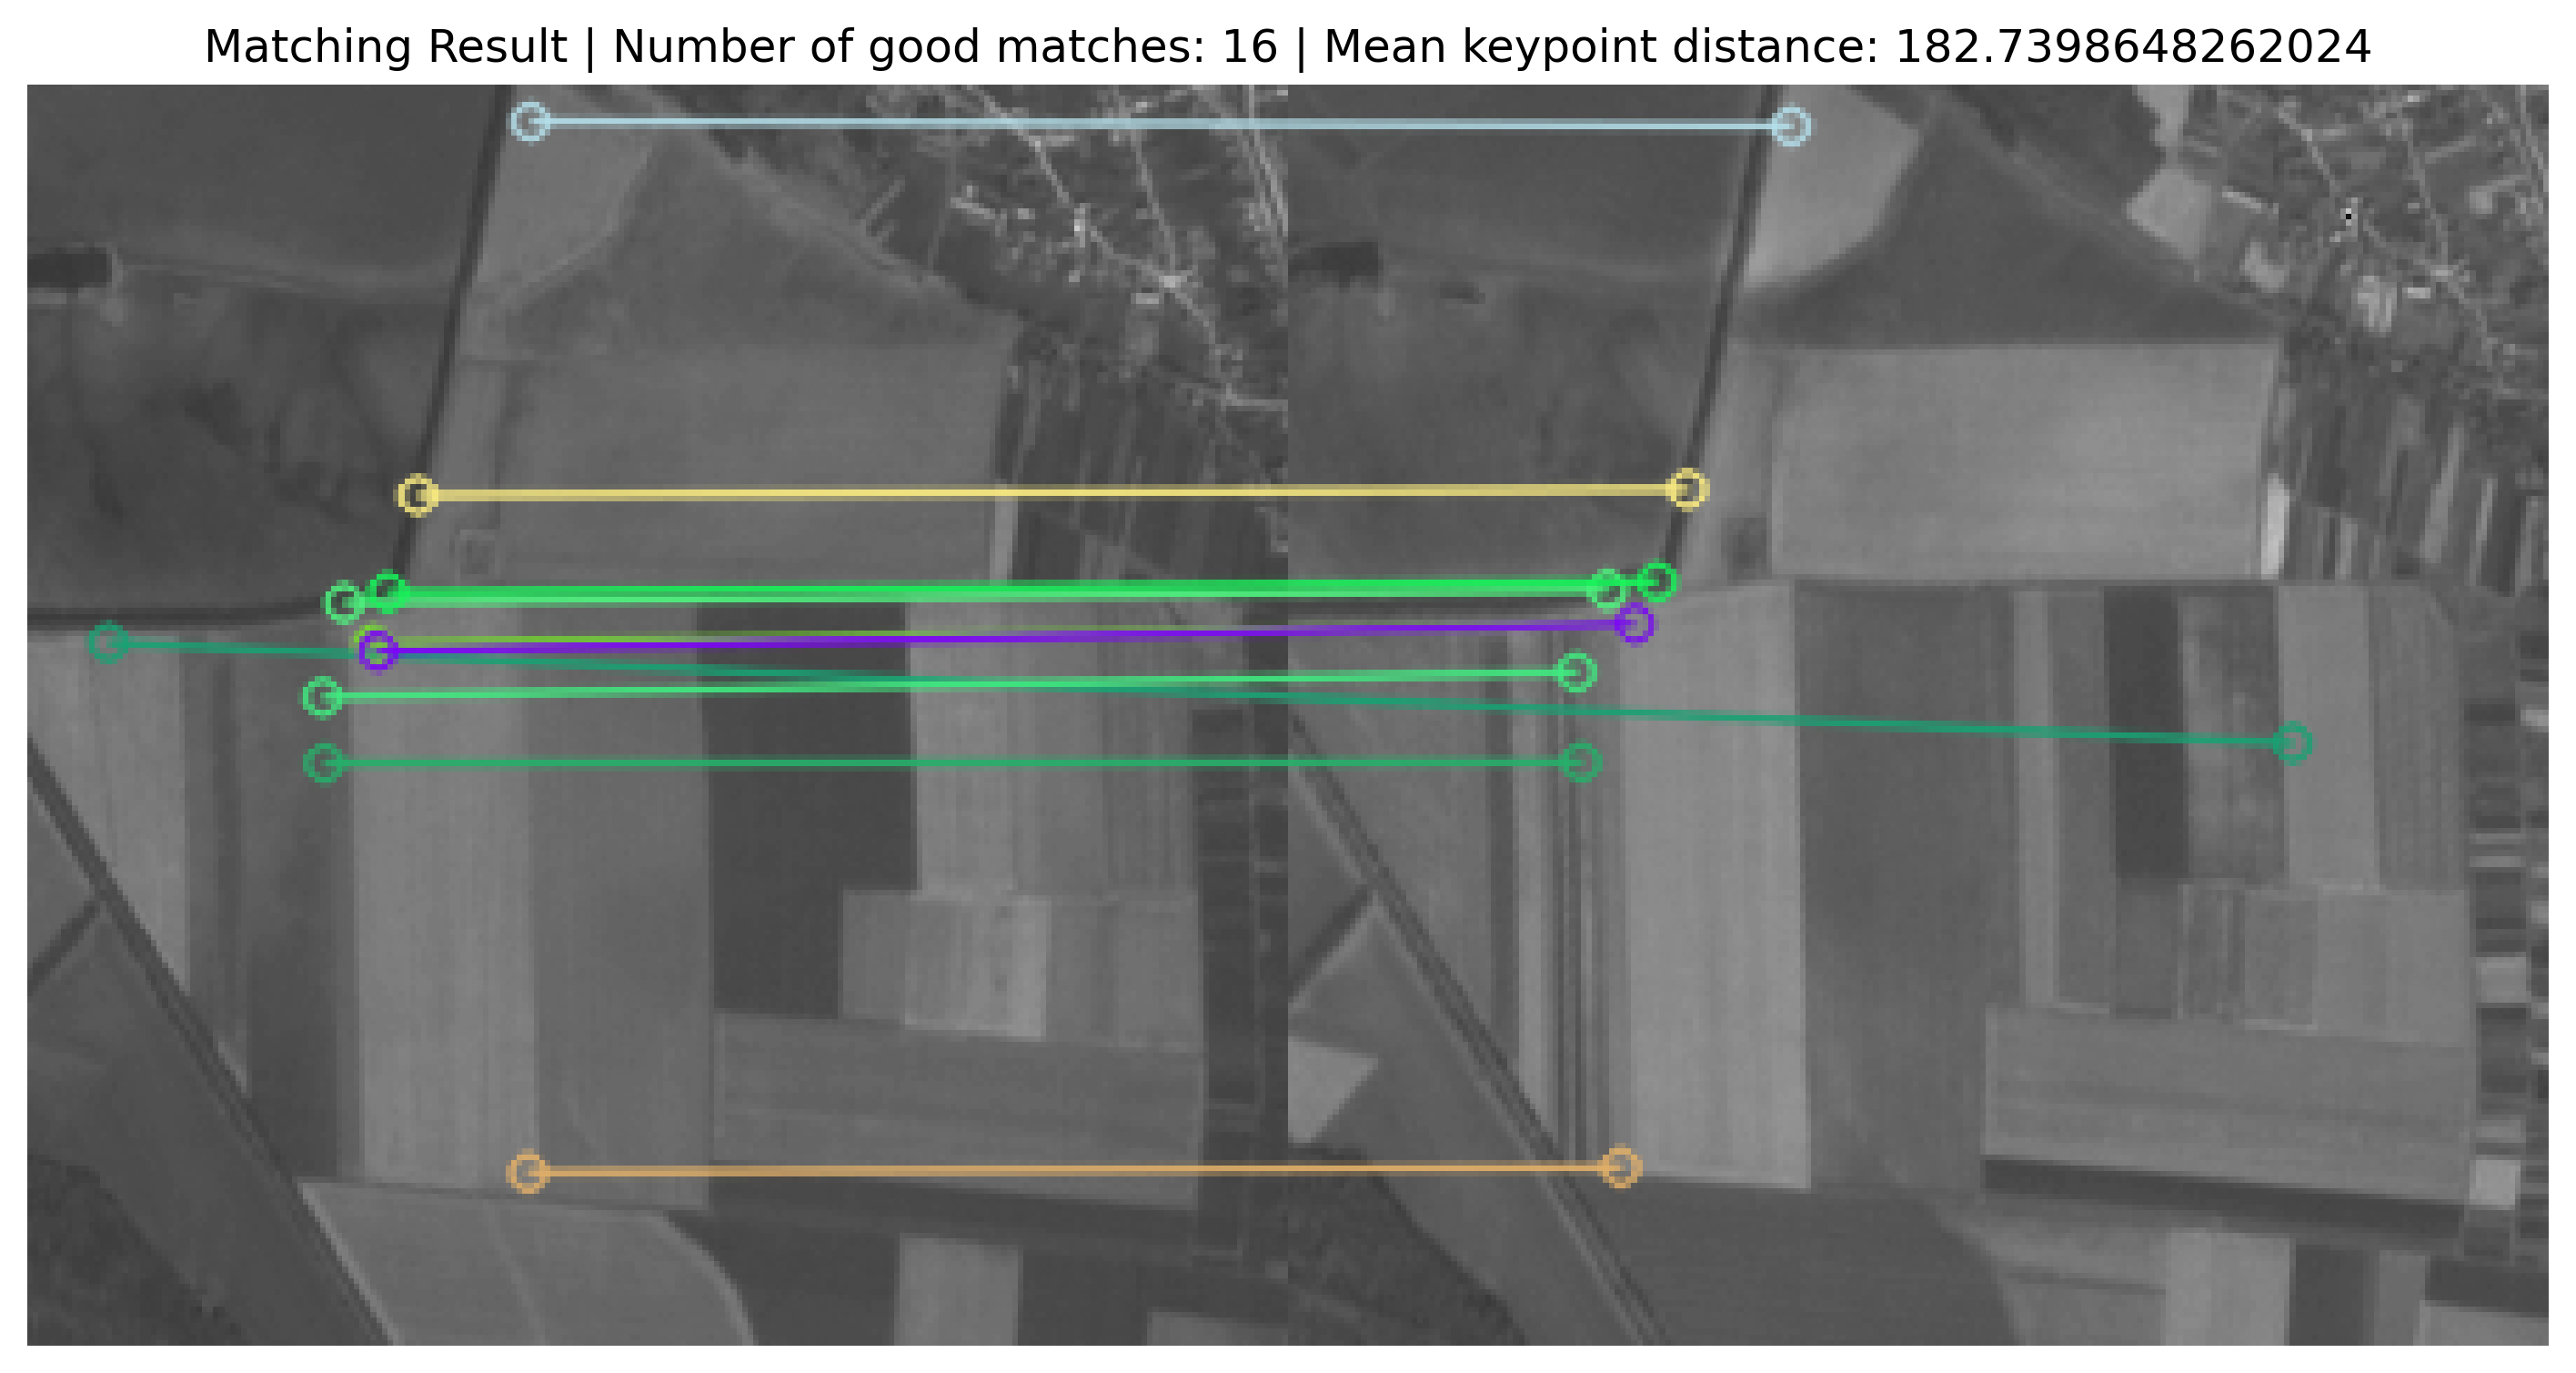

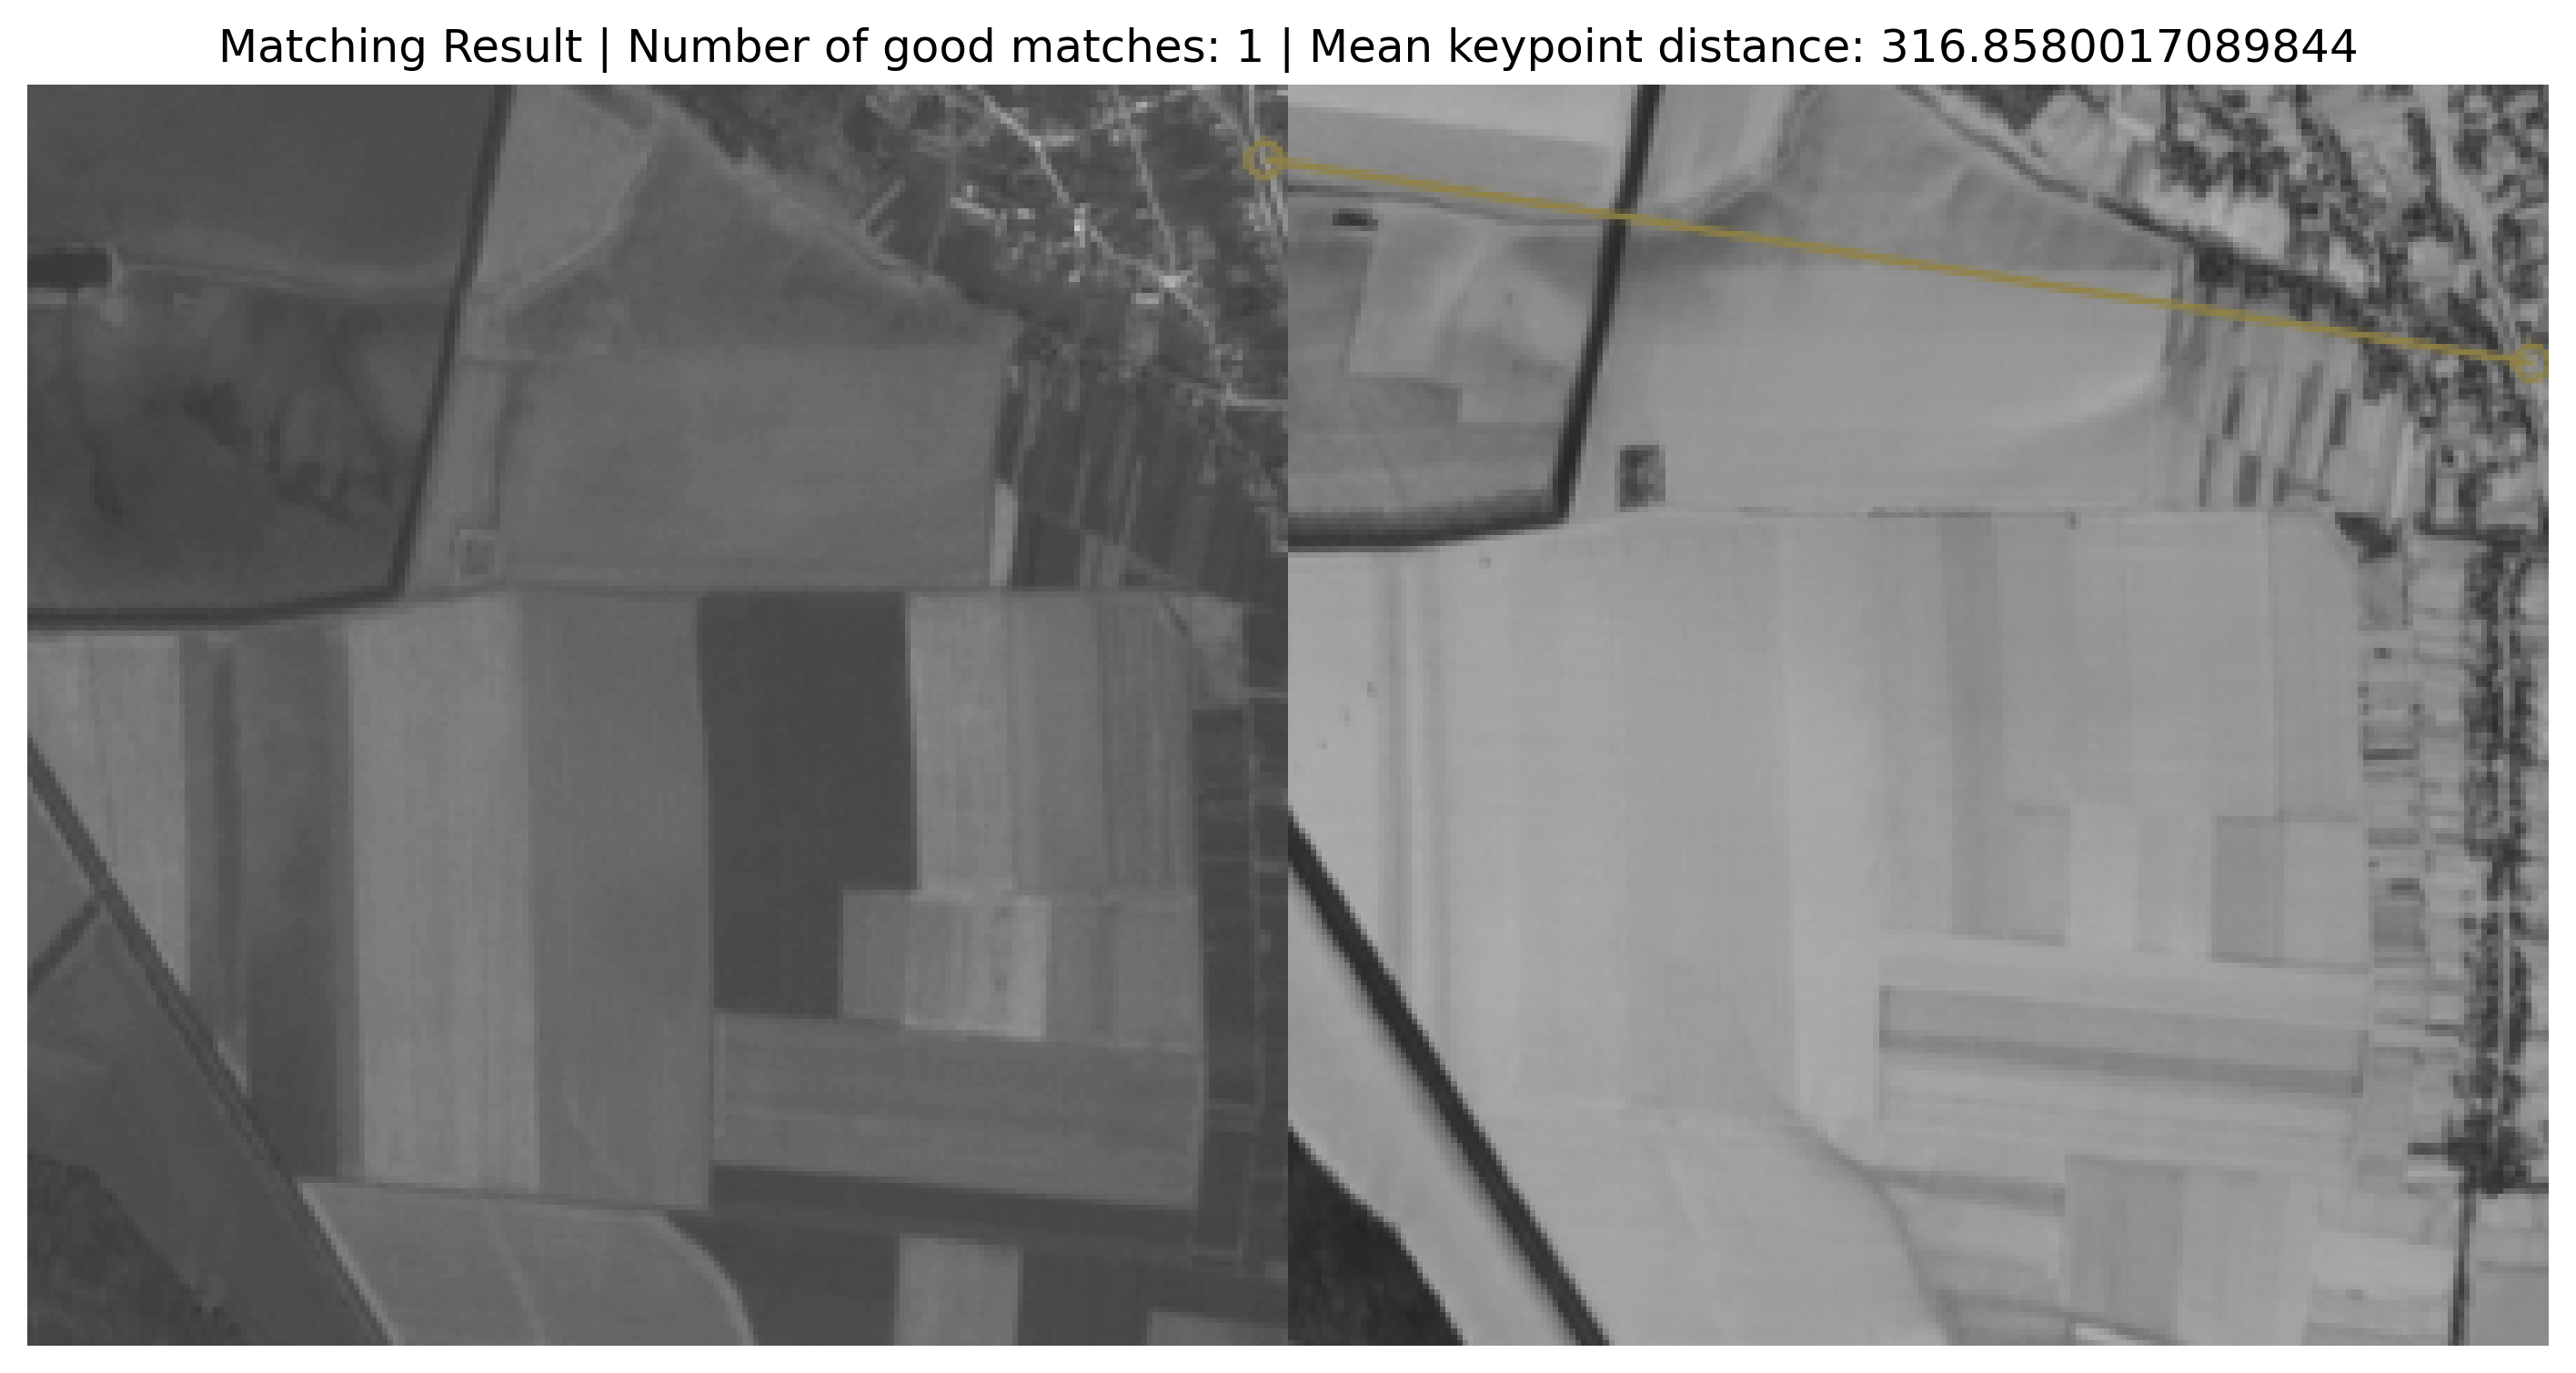

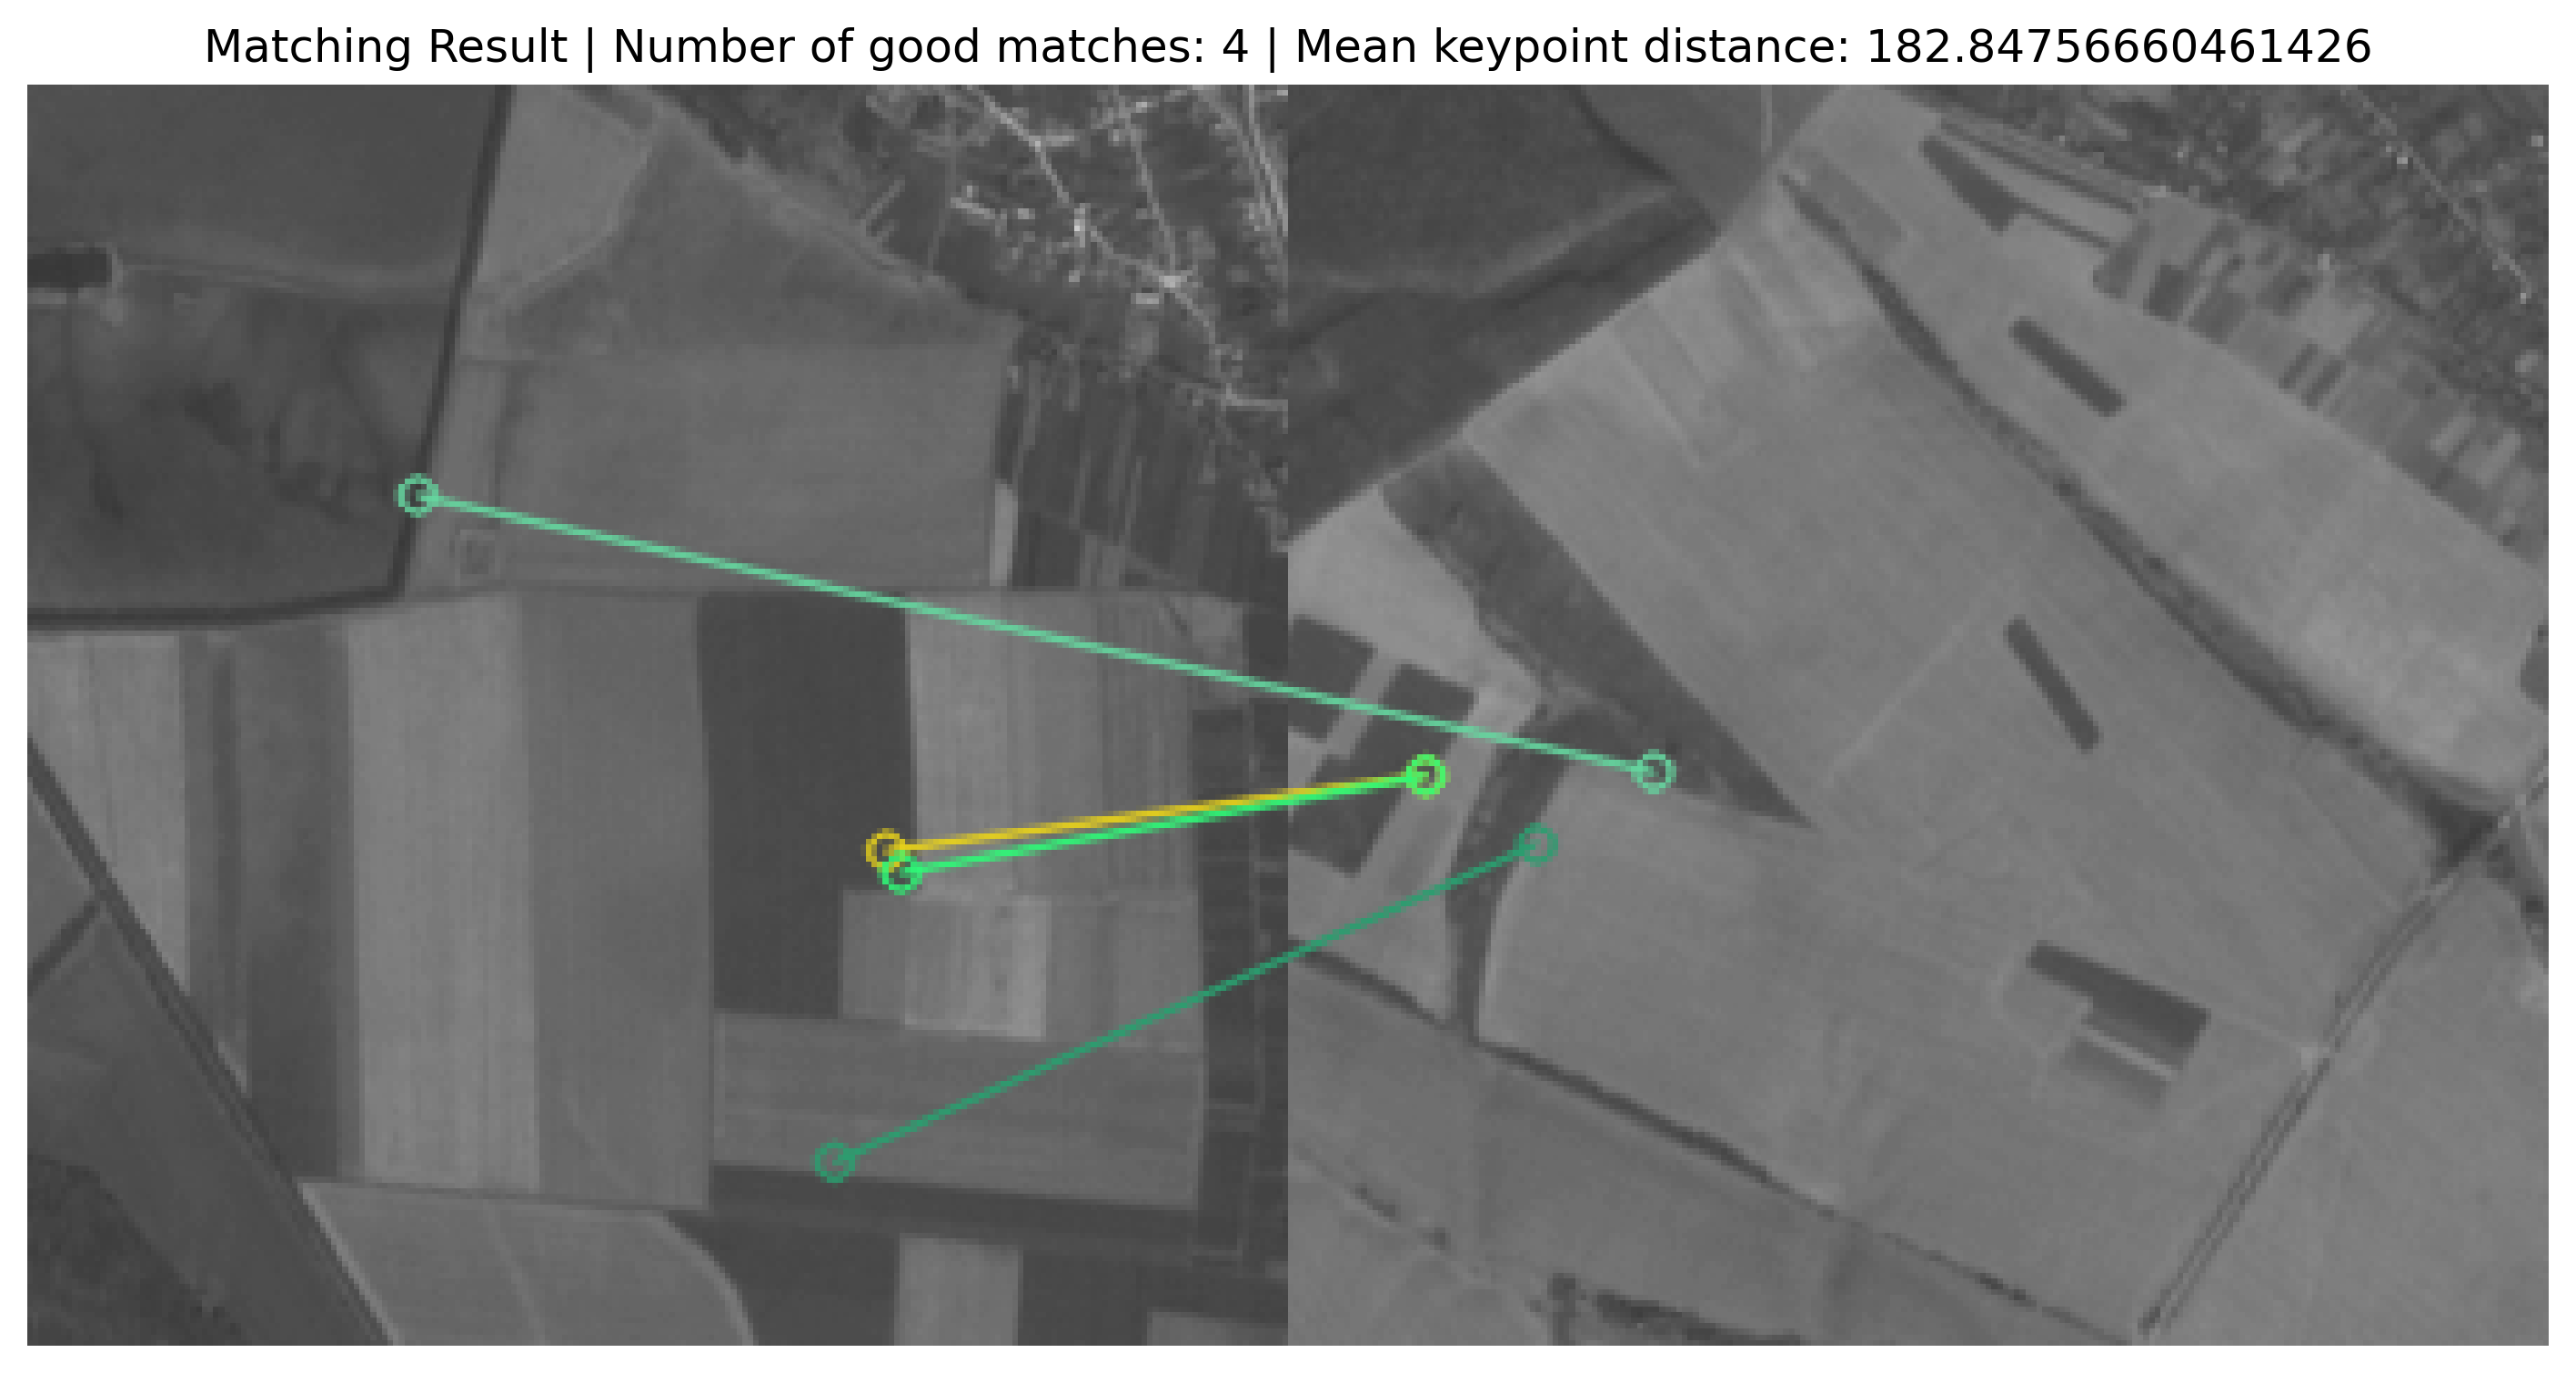

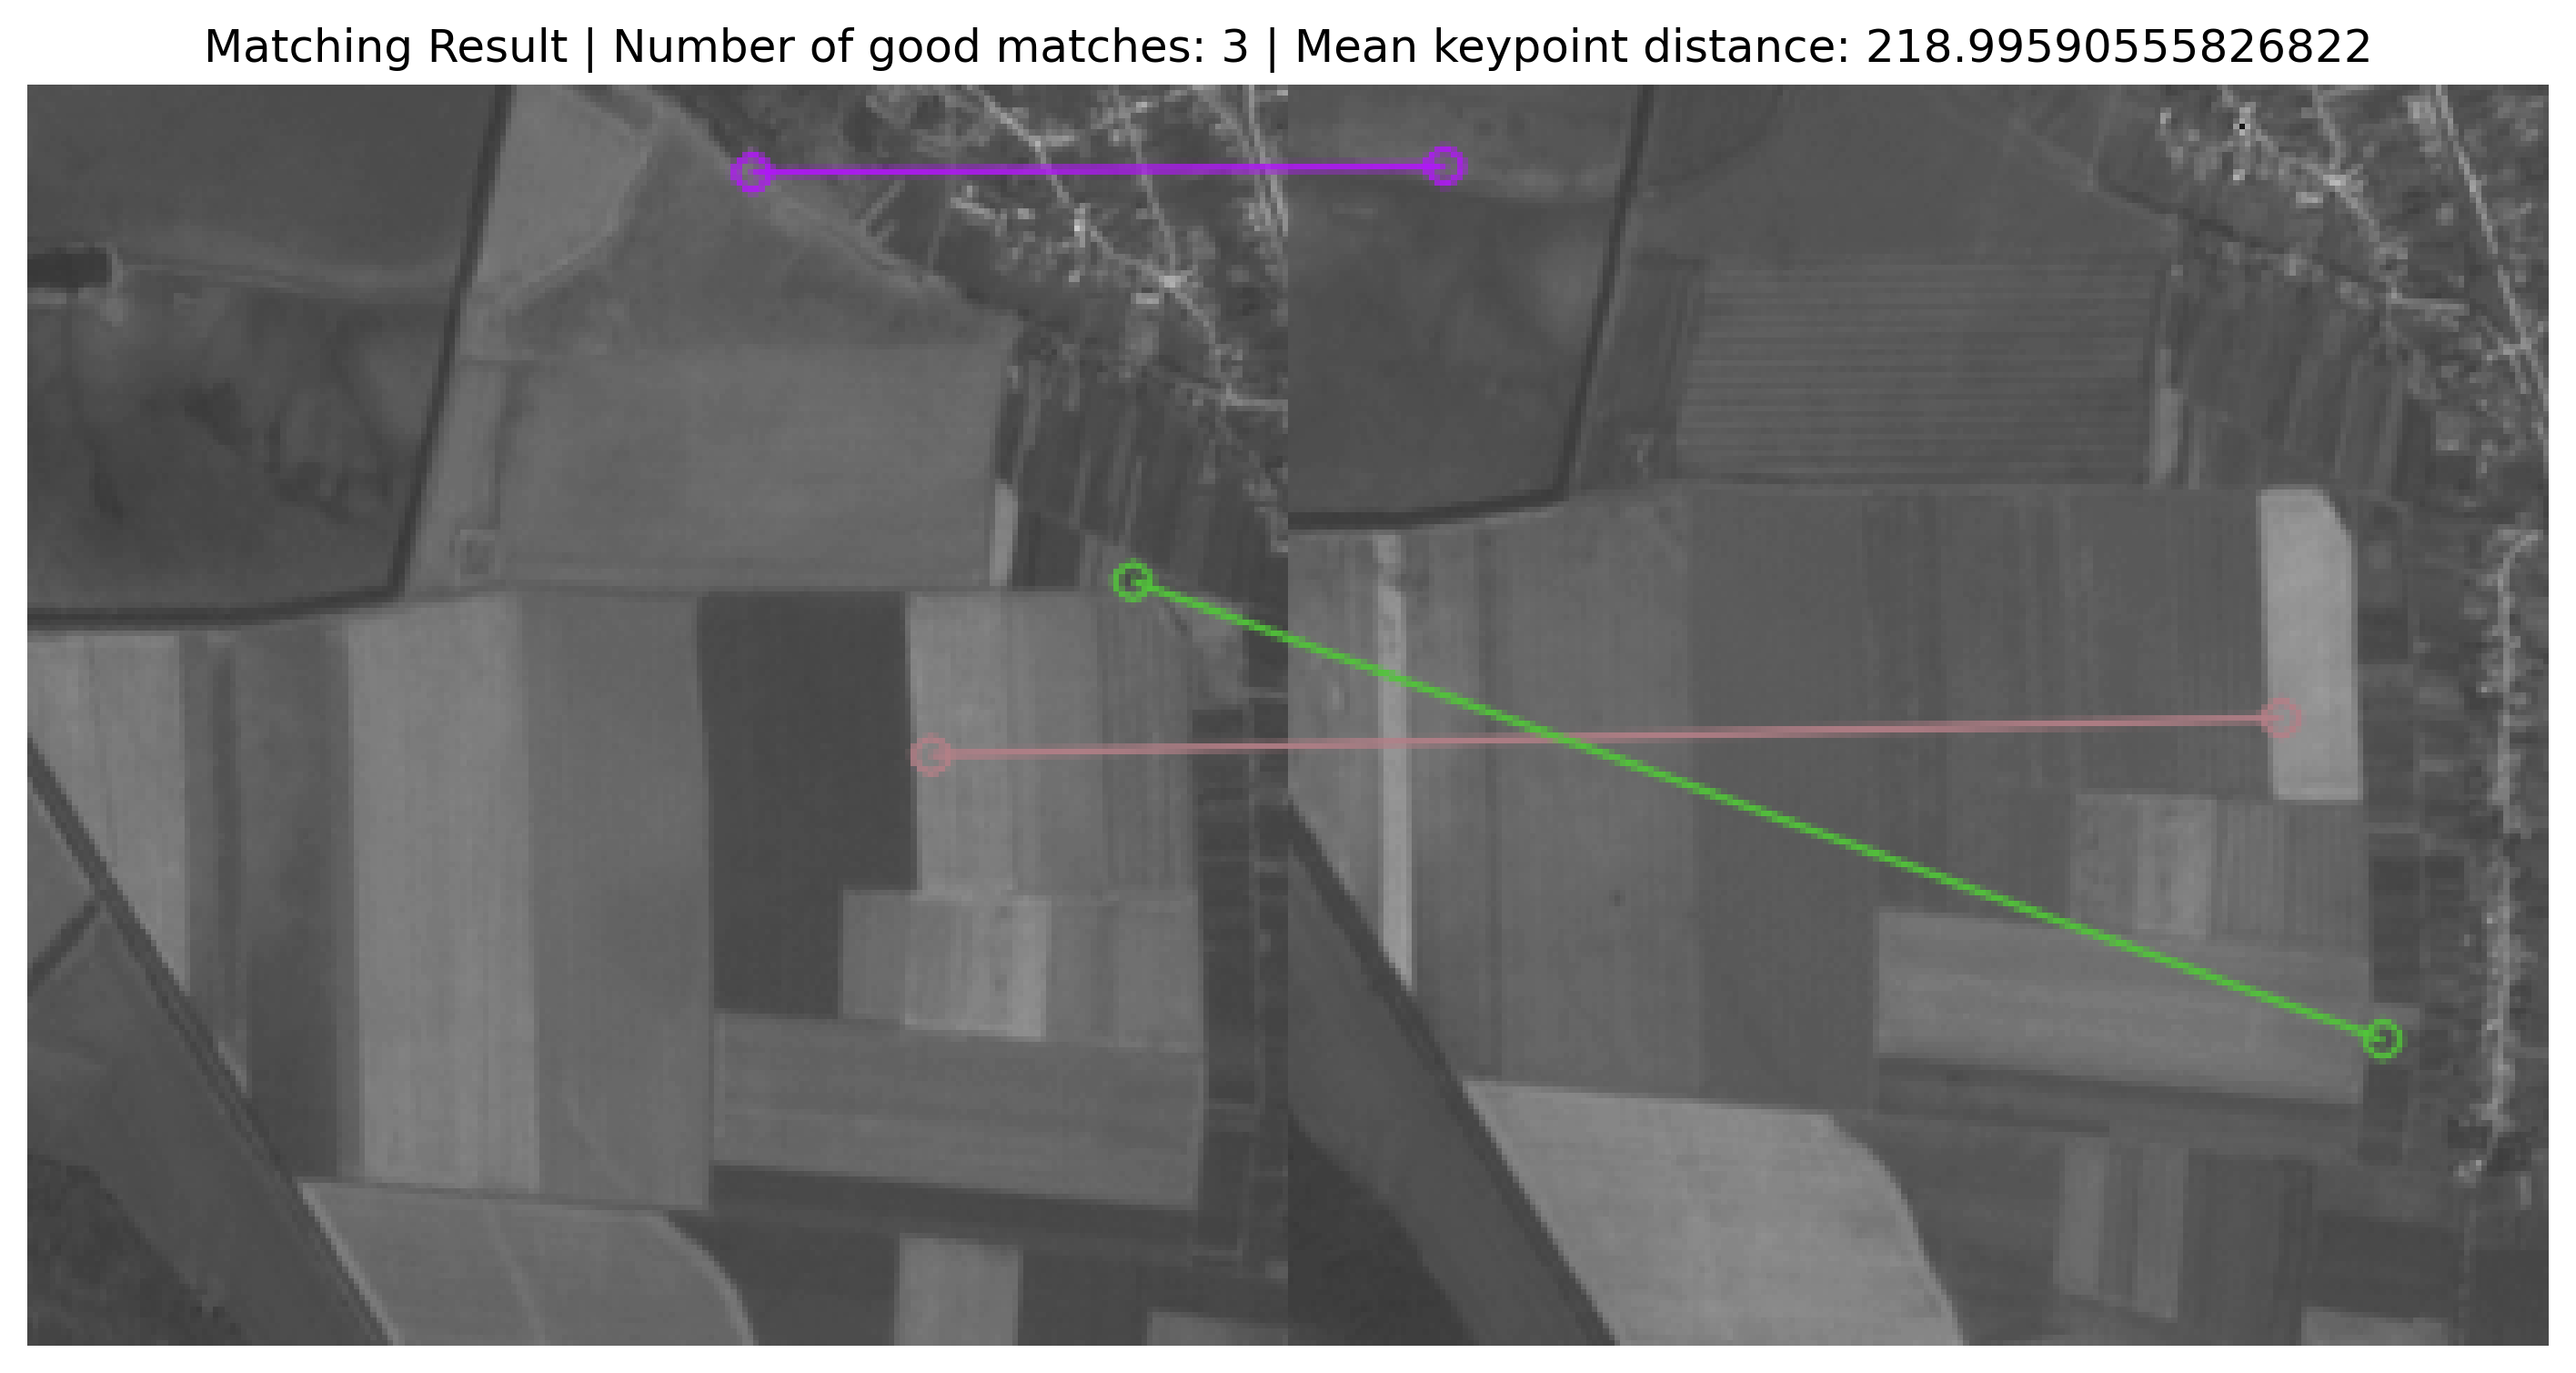

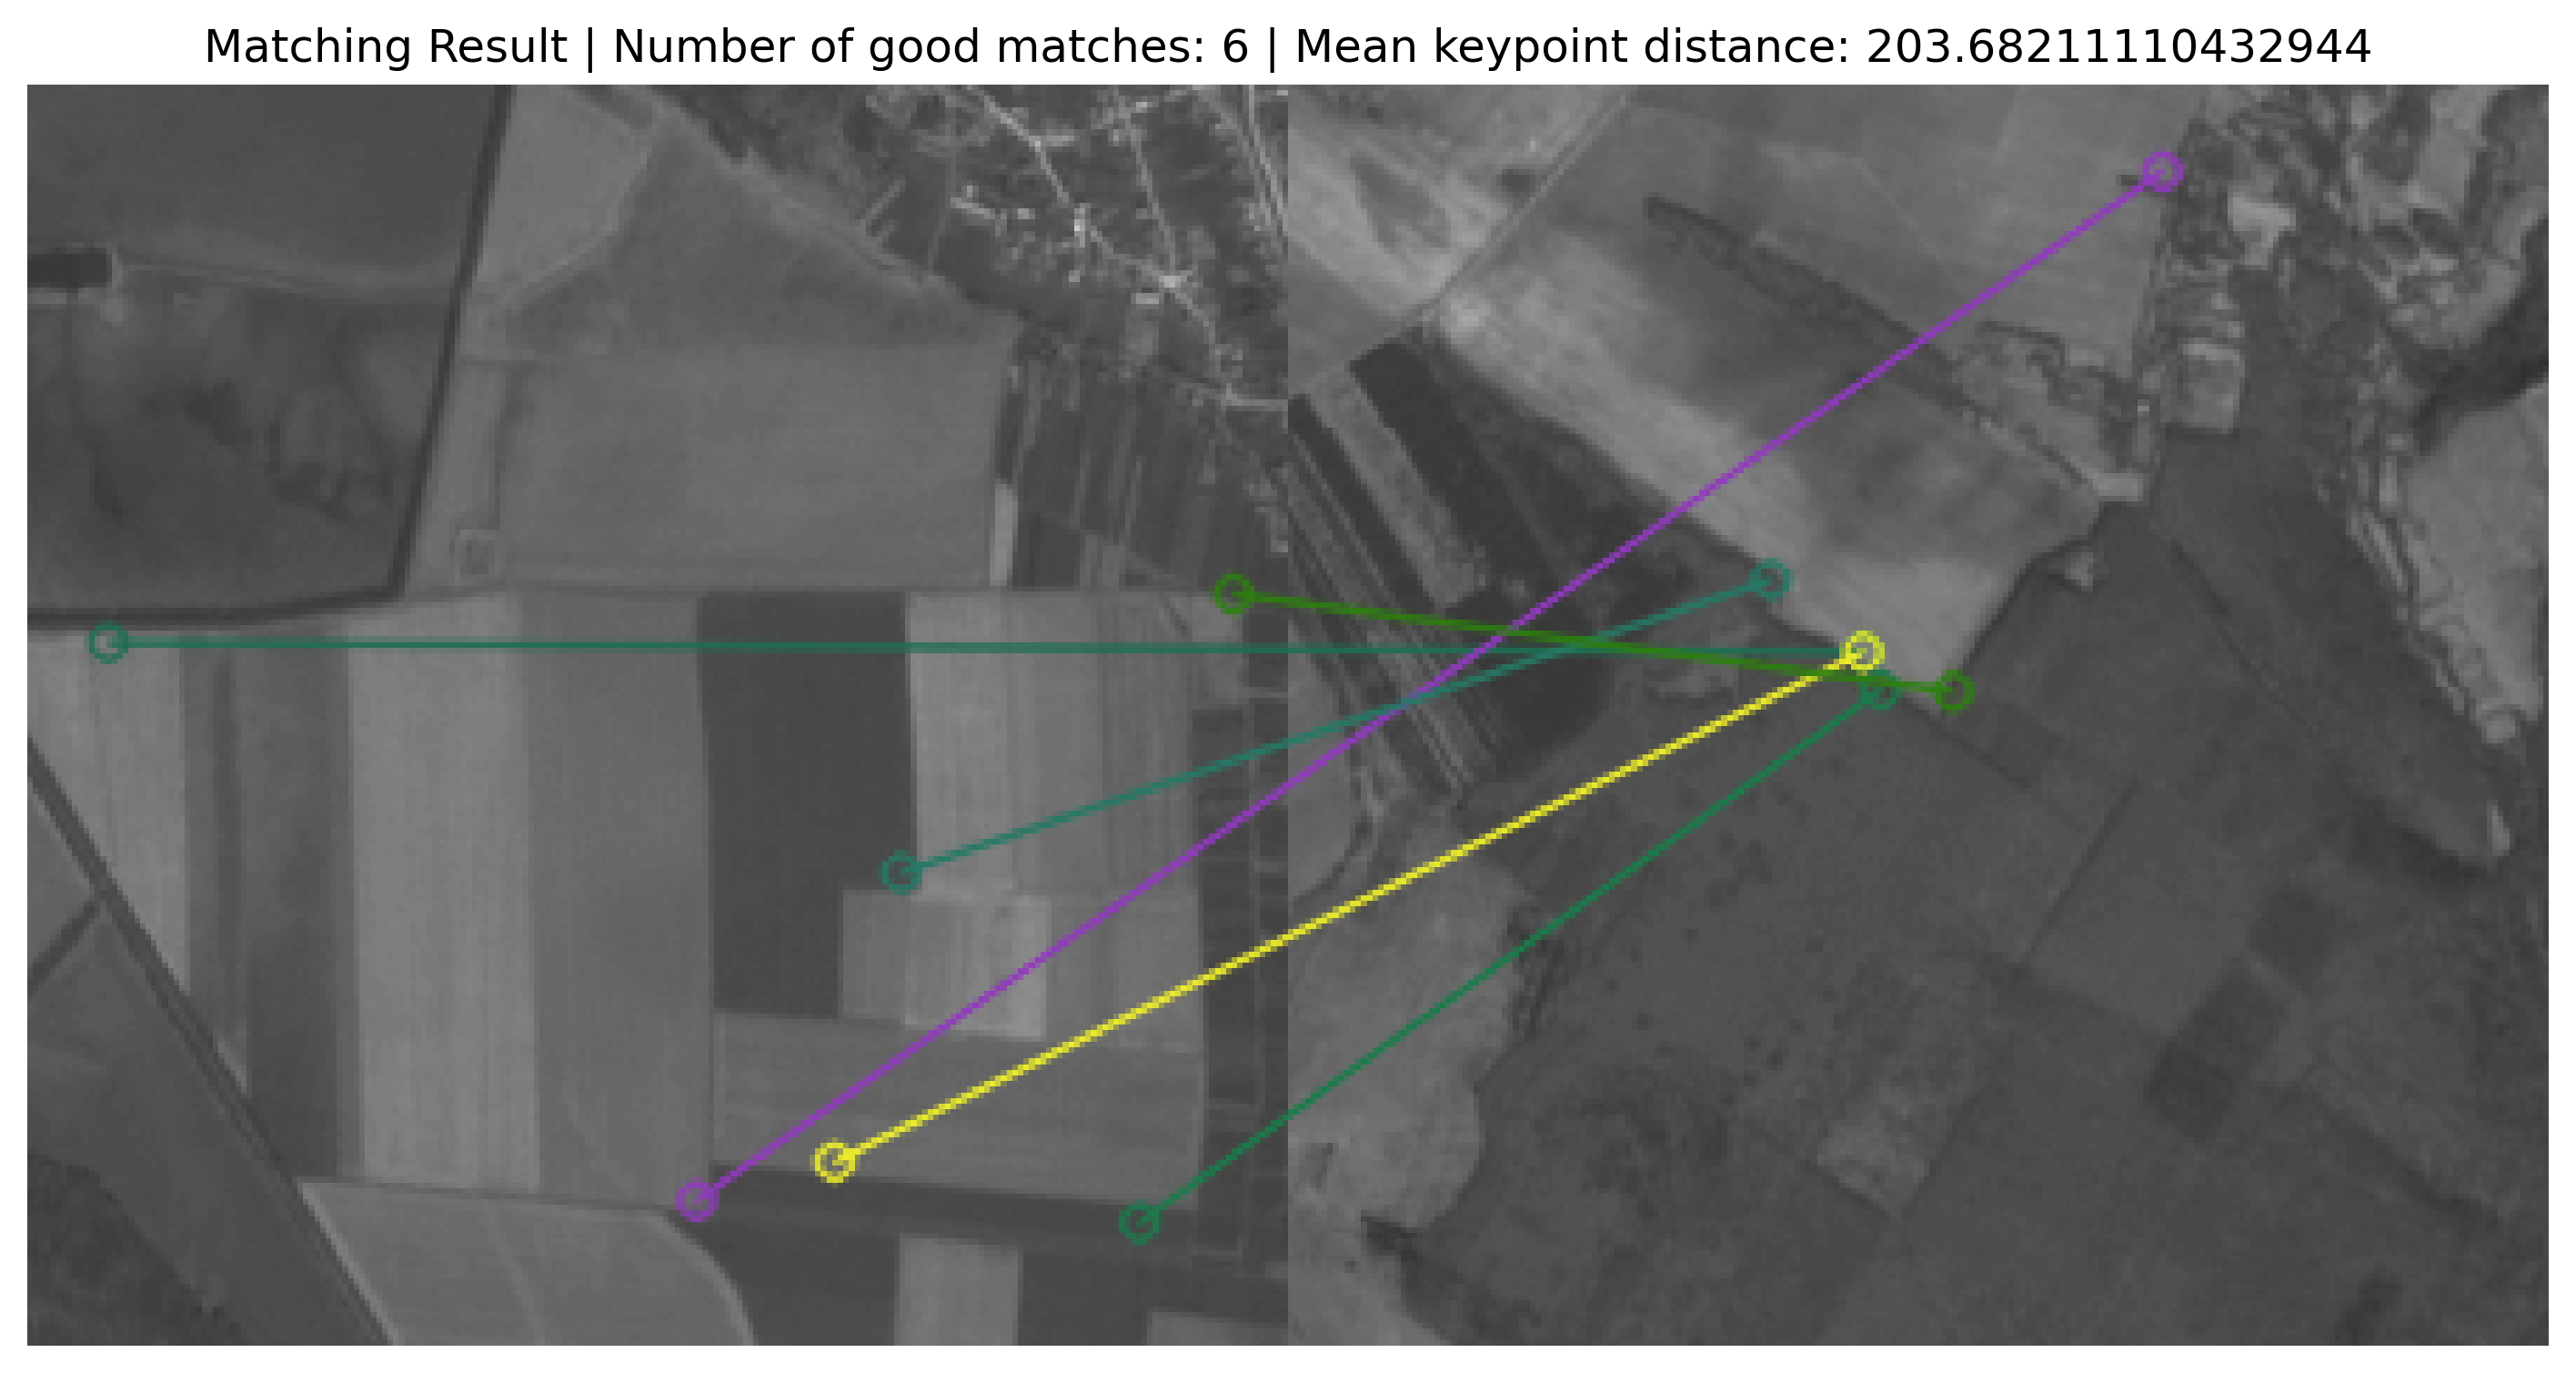

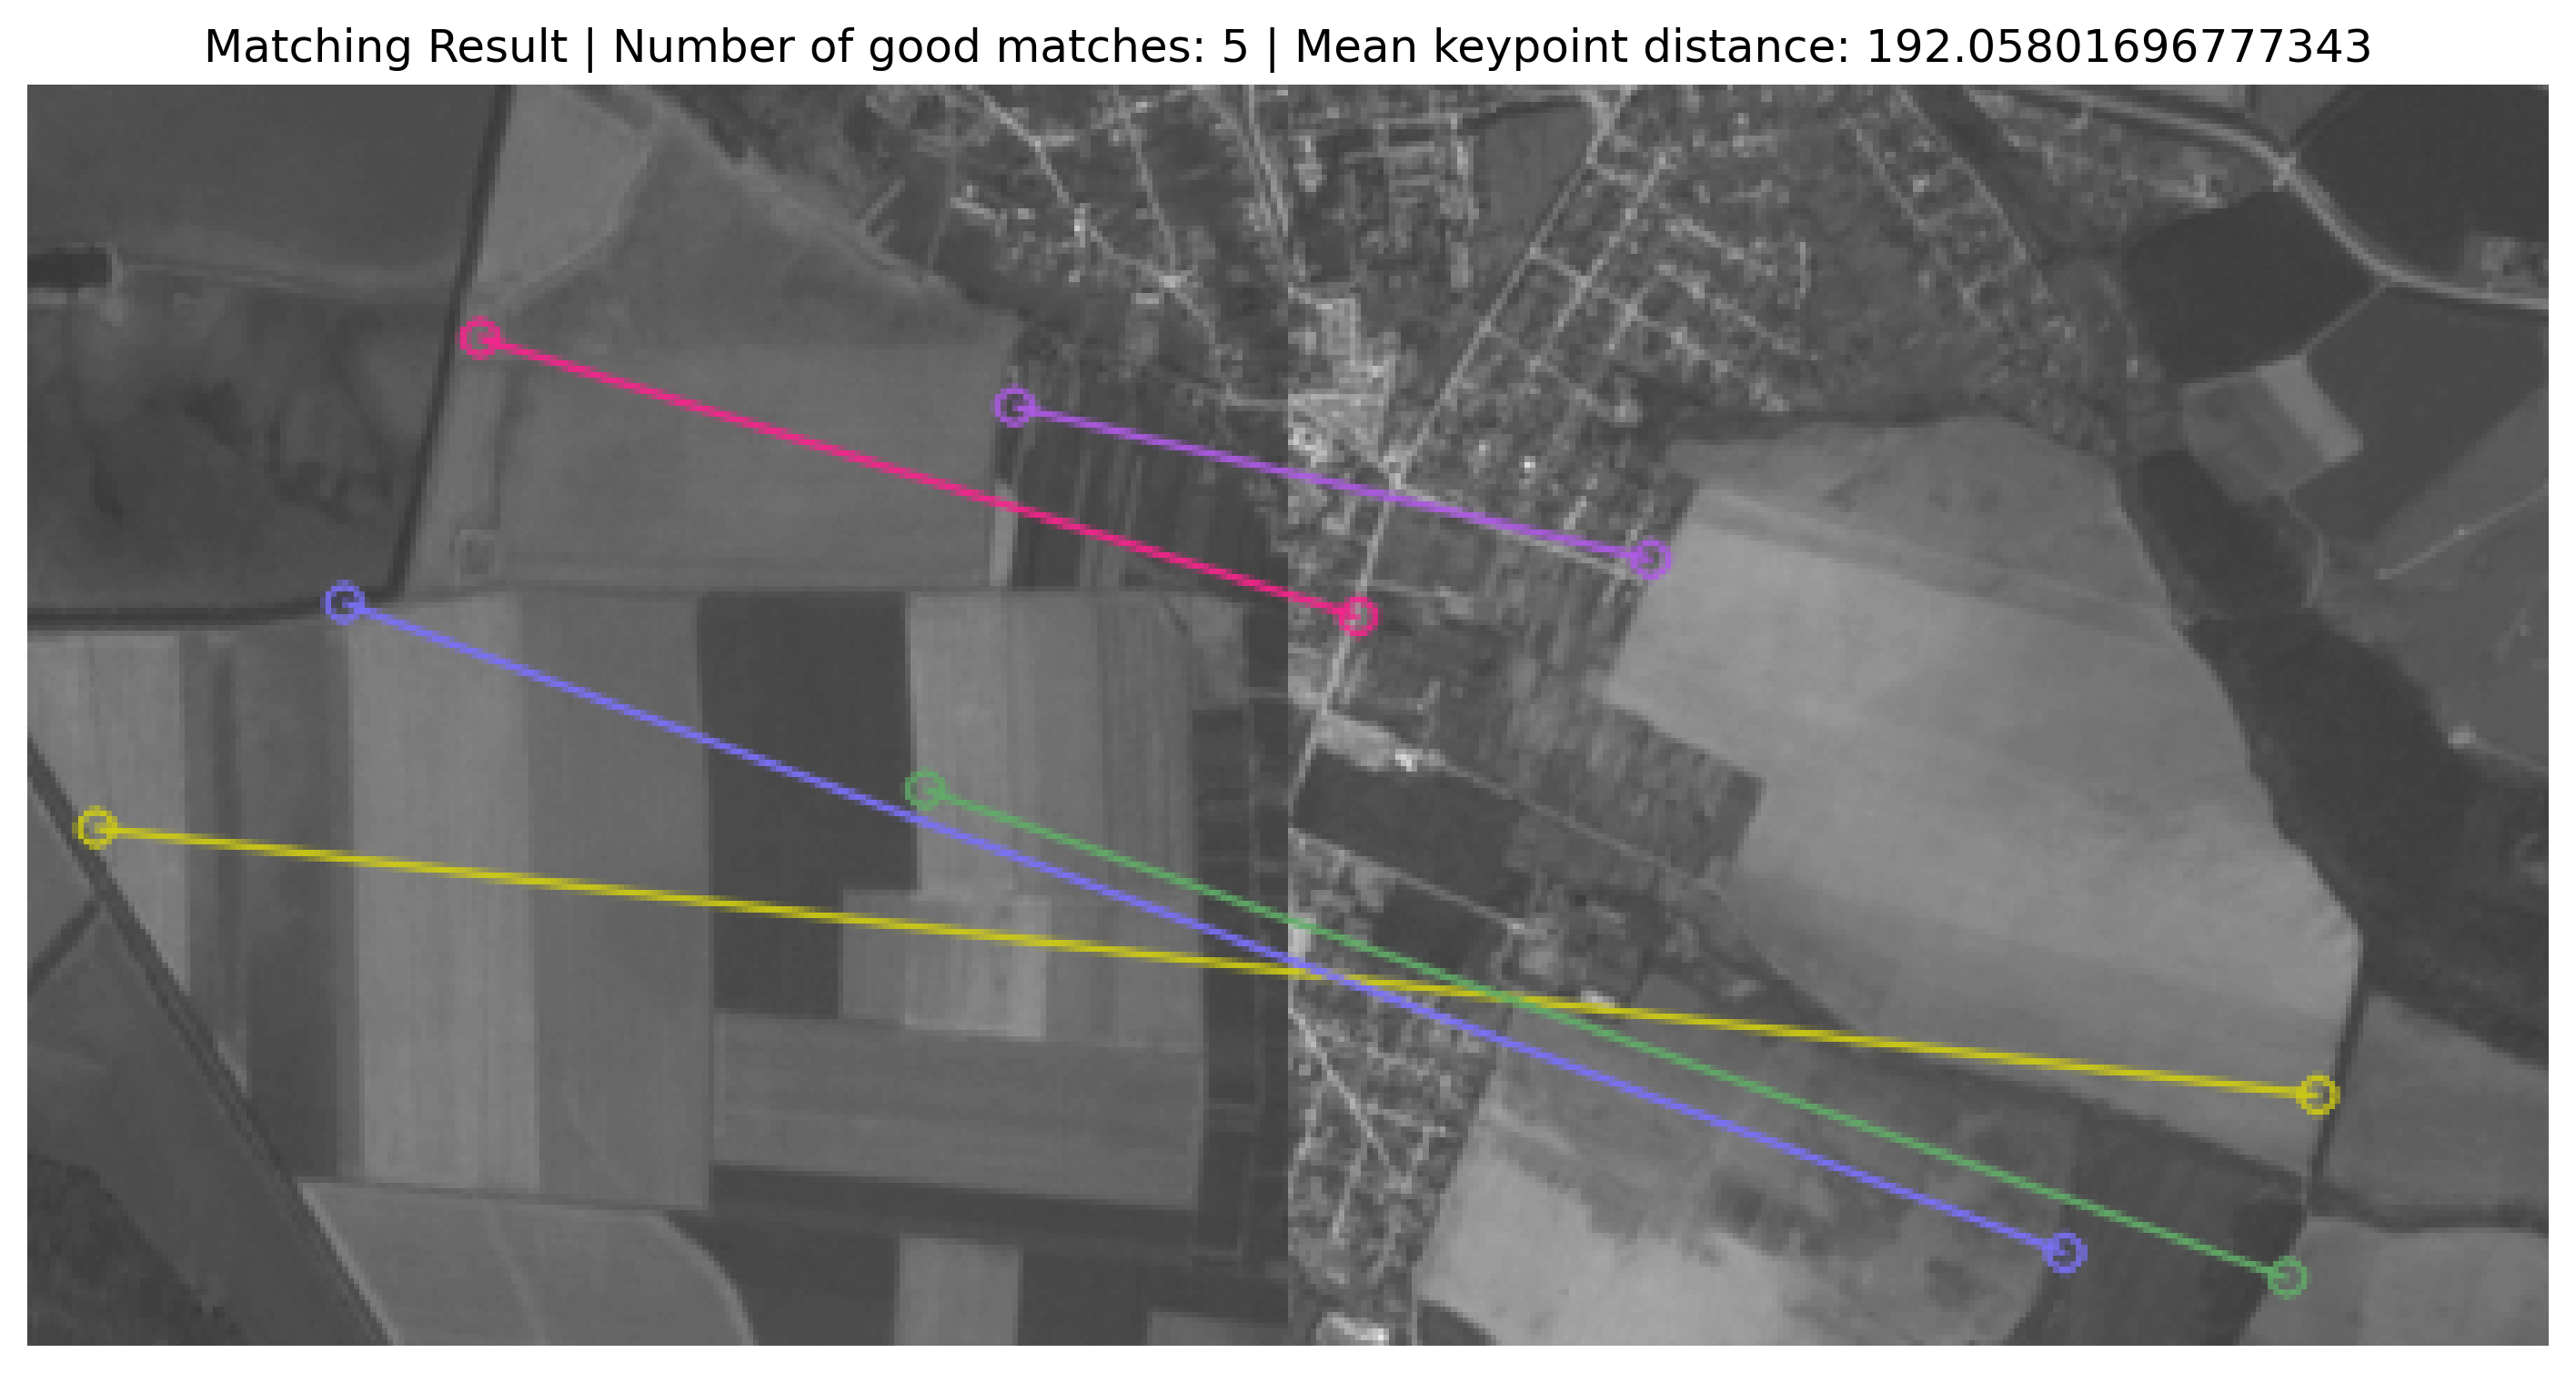

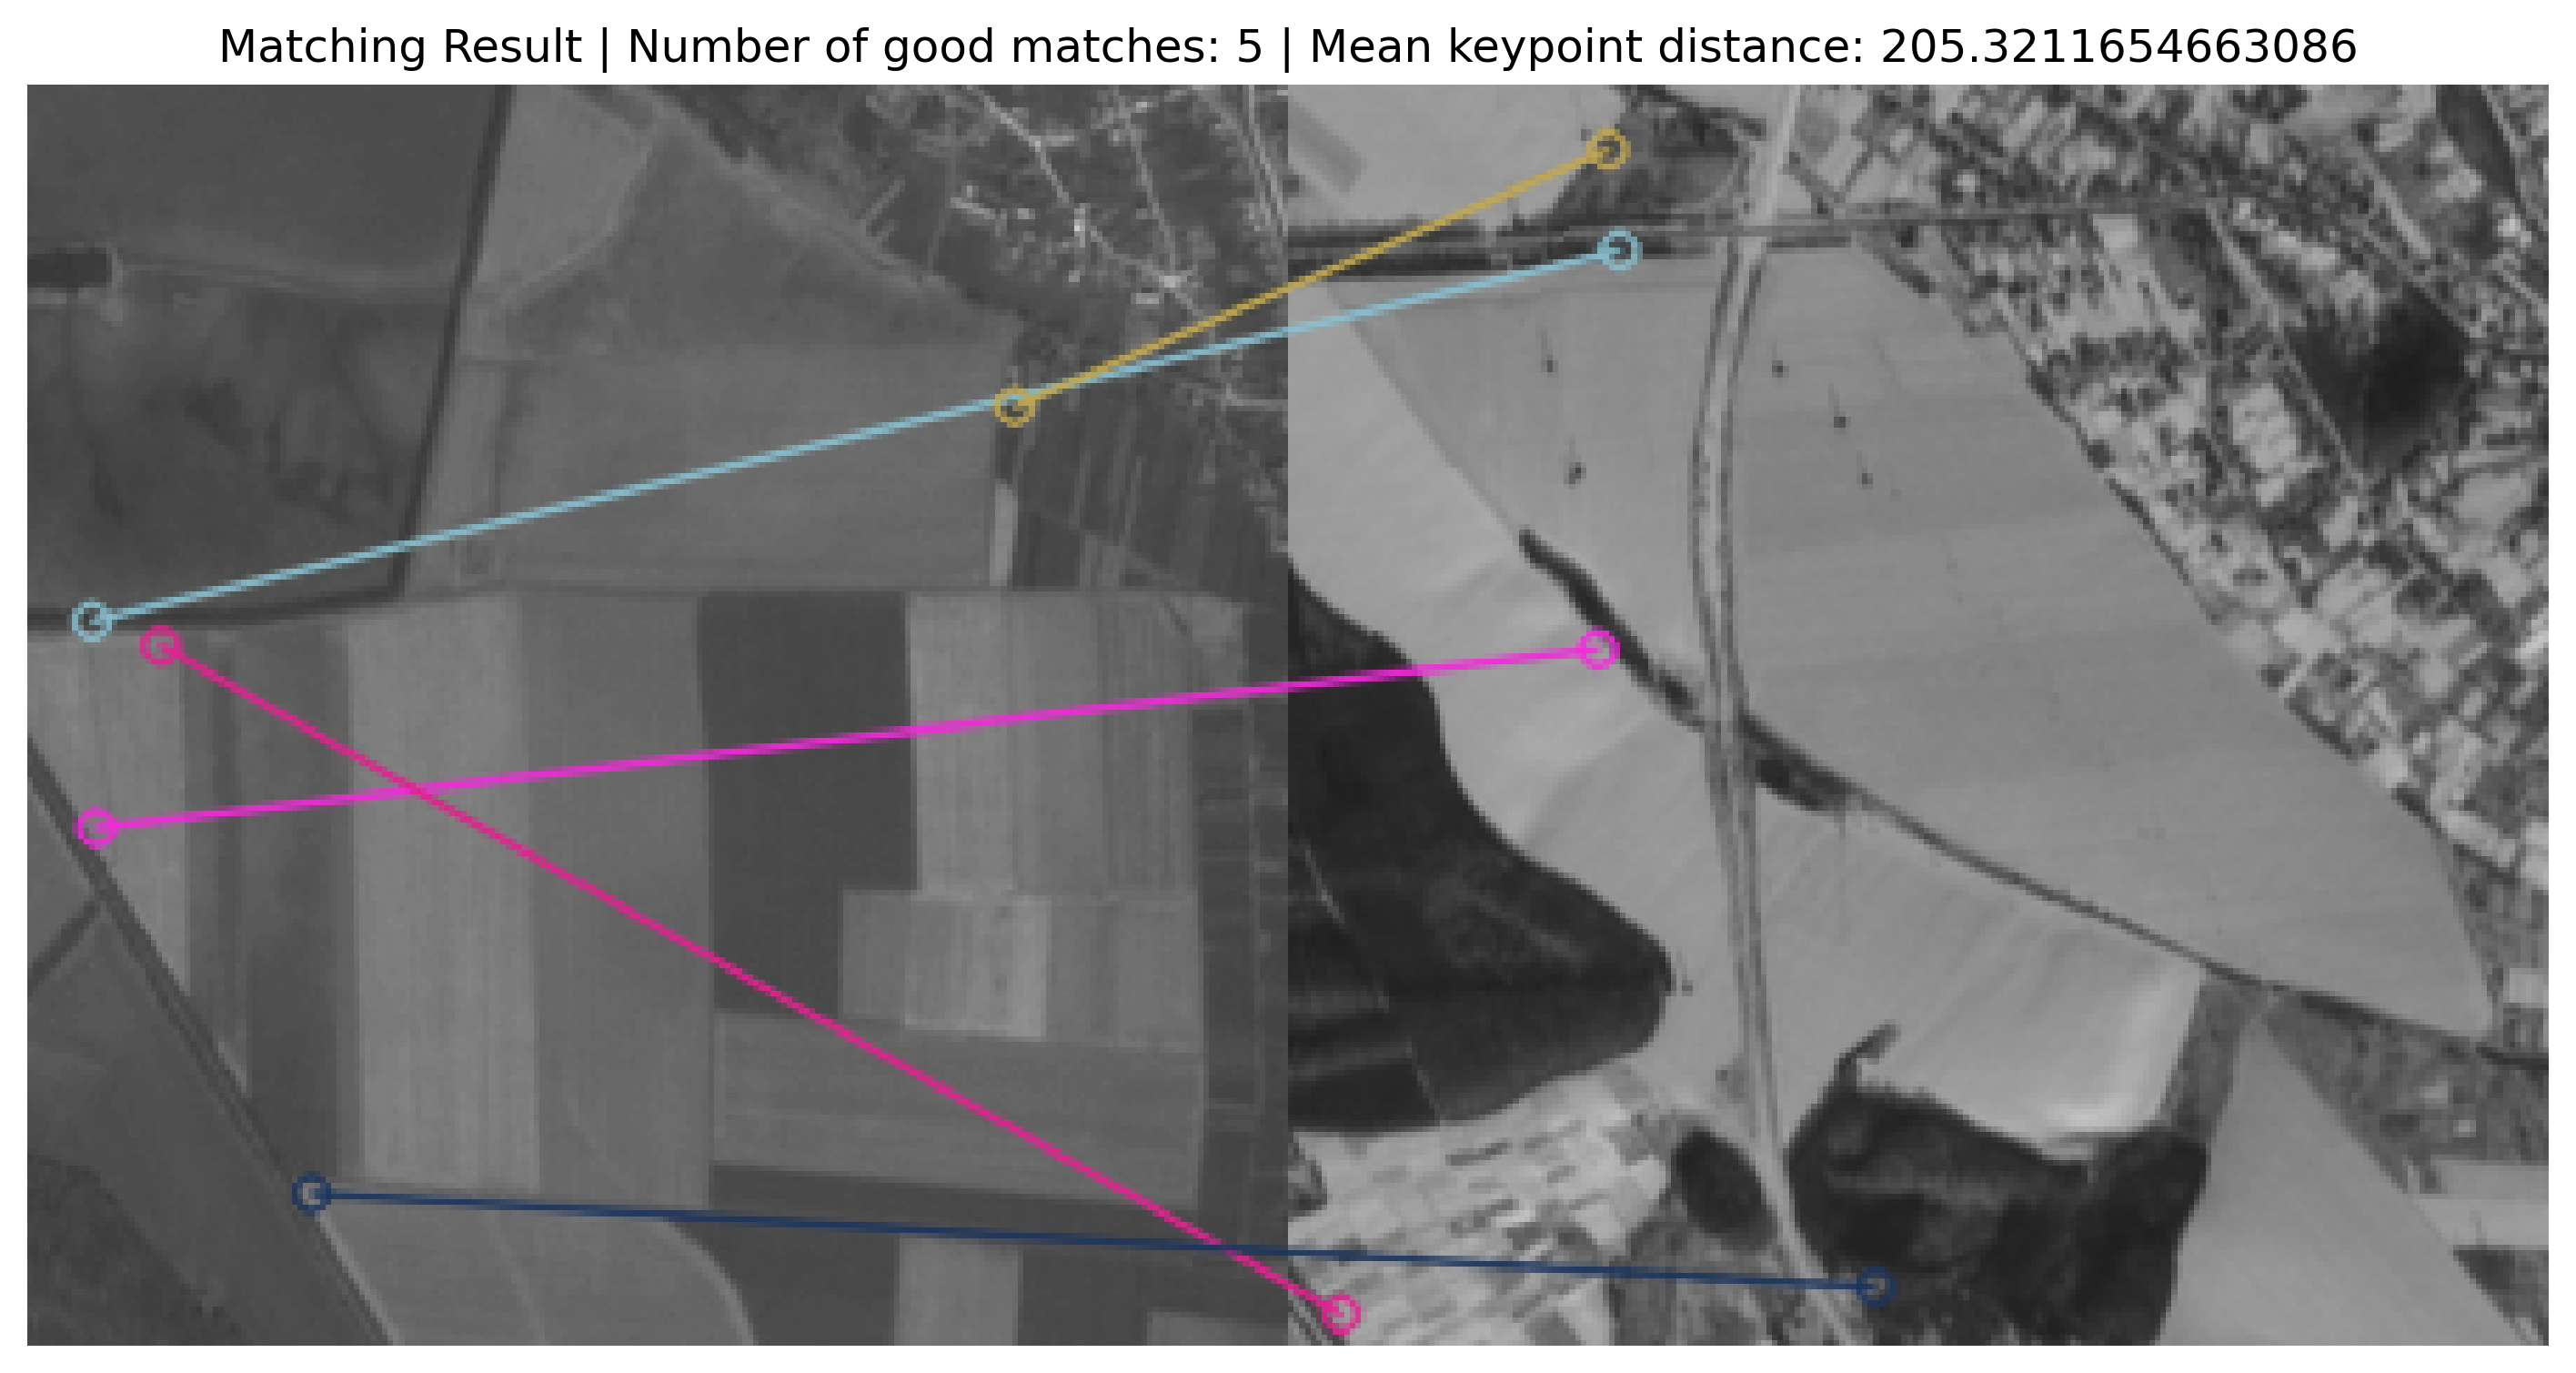

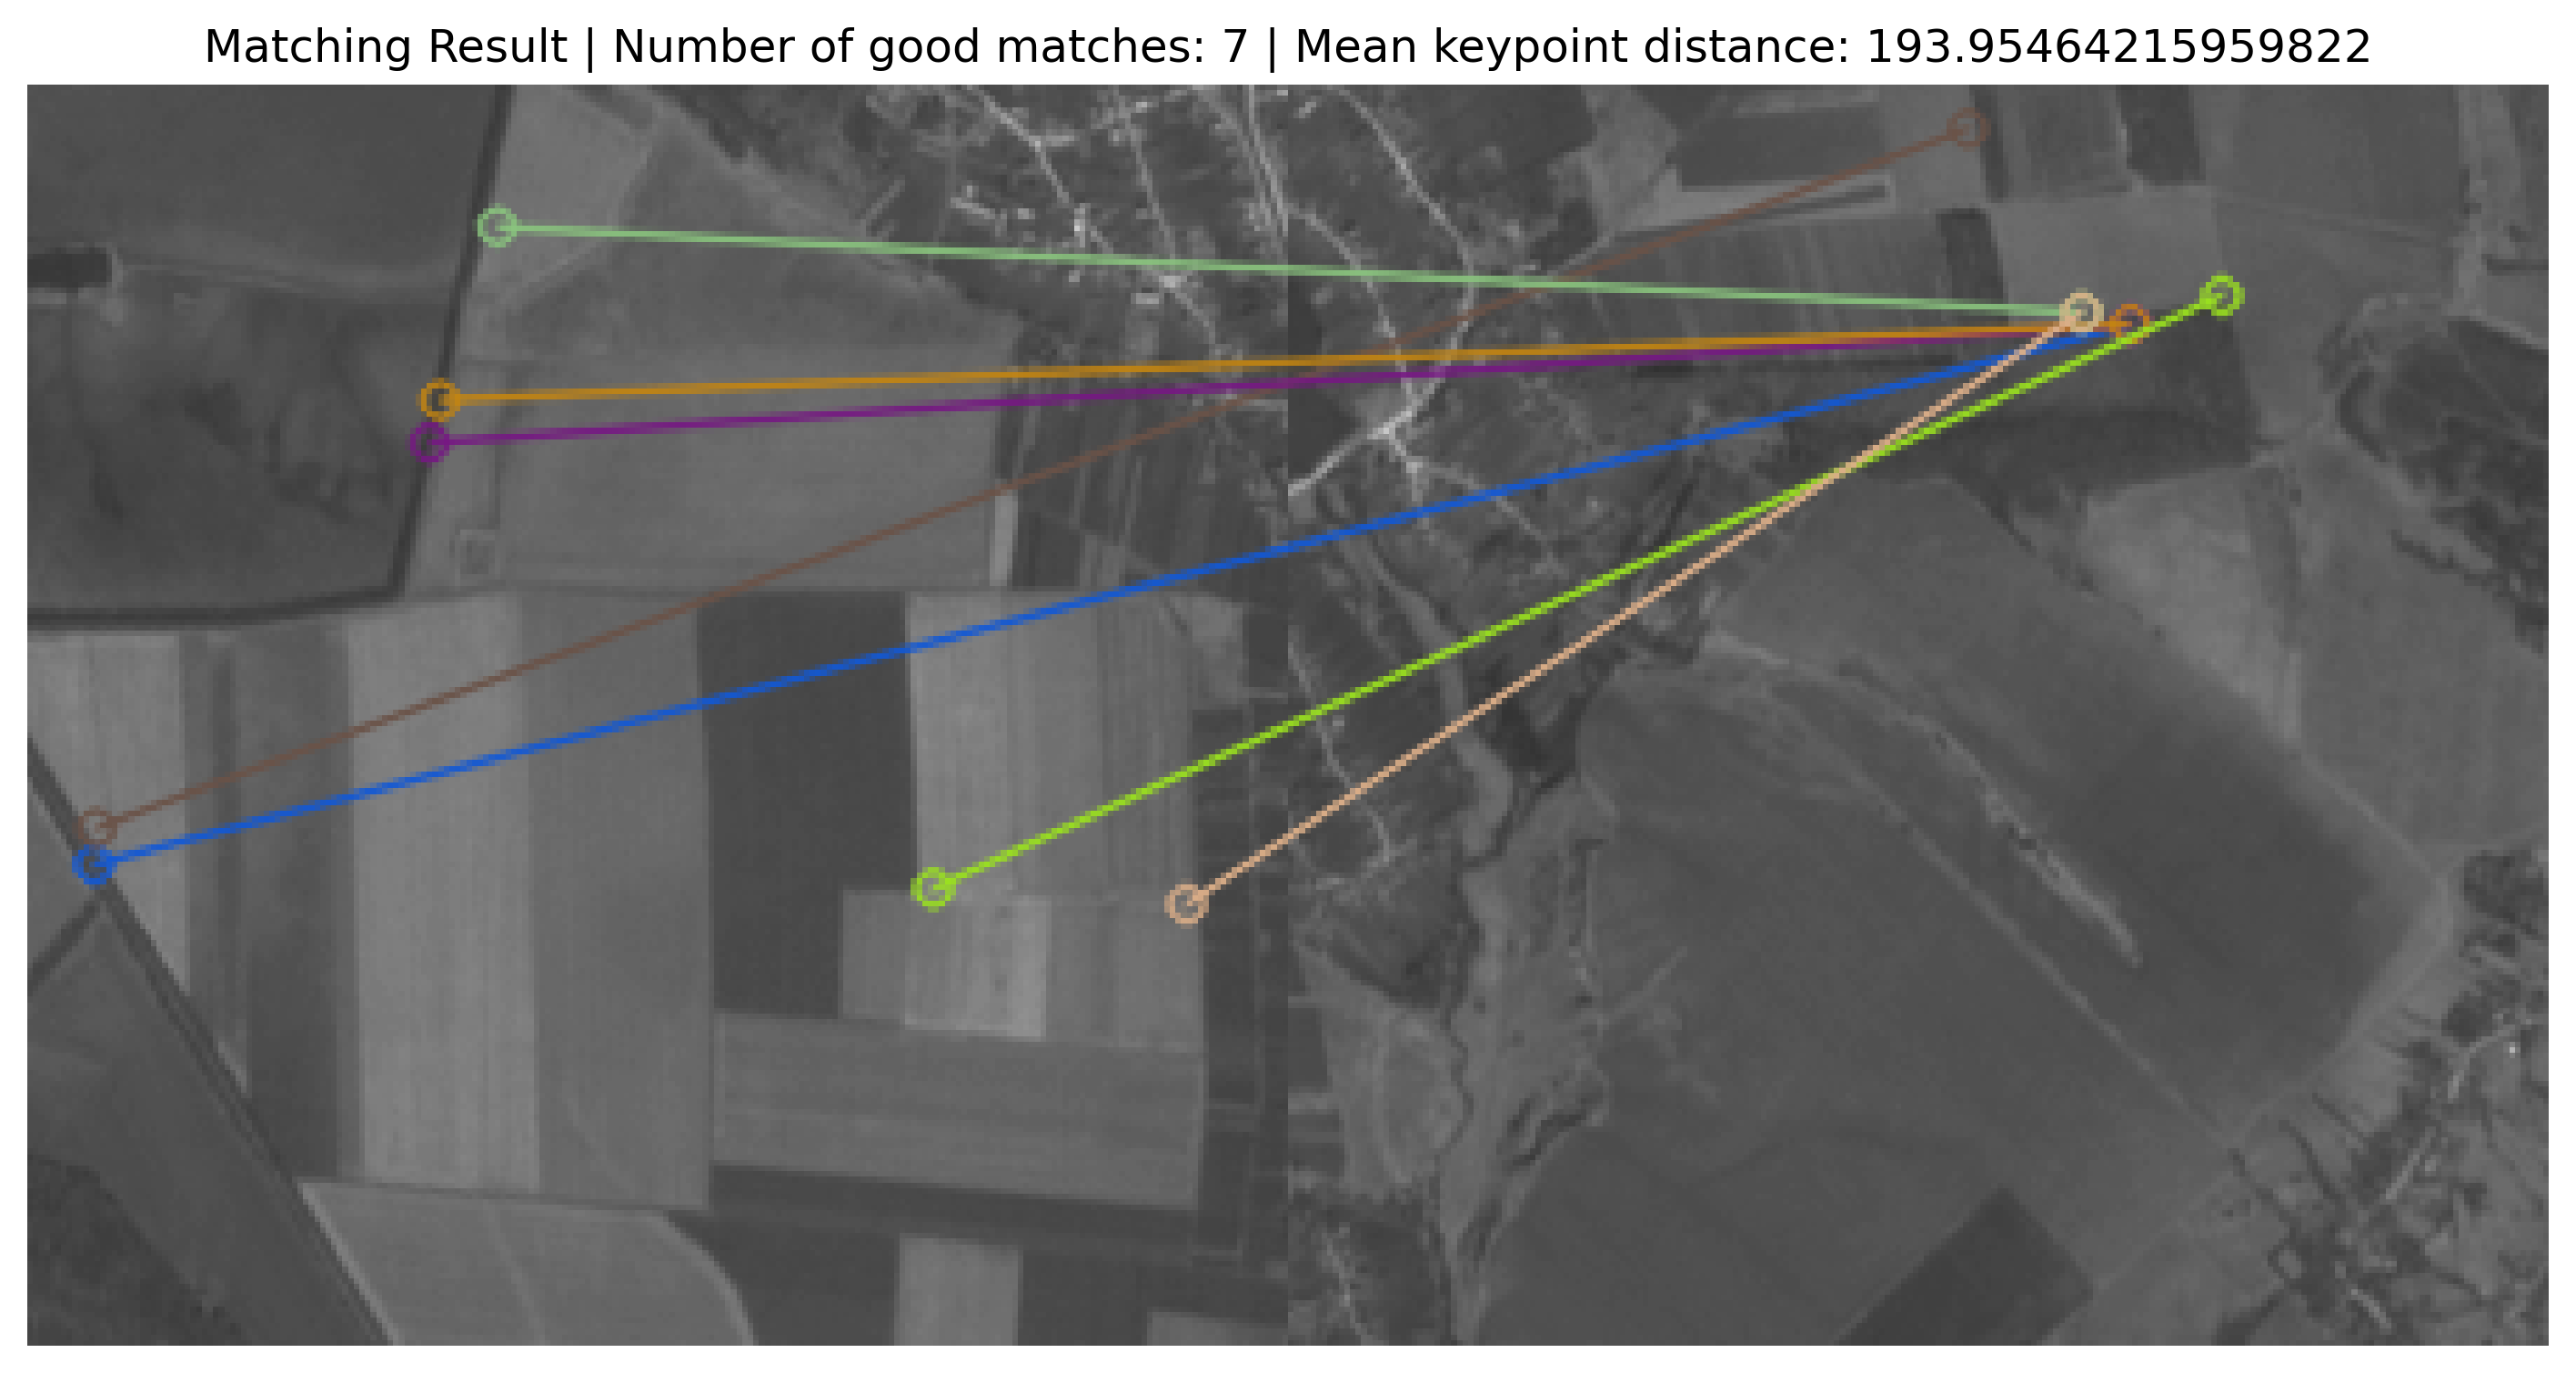

In [53]:
get_random_image_and_predict_the_most_similar(filenames=all_filenames_test_prepared, 
                                              embeddings_dict=embeddings, 
                                              top_n=10,
                                              factor=3.5,
                                              bright_threshold=200, 
                                              dark_threshold=40)